In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
import util
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from scipy import stats

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

color_dict = {"default300k":'gray', "lsascent300k":'darkcyan', "lp05300k":'cornflowerblue', "lpls300k":'darkorange',
              "default304k":'gray', "lsascent304k":'darkcyan', "lp05304k":'cornflowerblue', "lpls304k":'darkorange',
              "default":'gray', "lsascent":'darkcyan', "lpfrz":'cornflowerblue',"lp05":'cornflowerblue', "lpls":'darkorange'}

sims_dir = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations"
plt.rcParams['font.size']=15
chunks={"ncol":10000}
qsmall=1e-8

# Part 1: Sensitivity Study

## Figure 1: snapshot of OLR and WVP for one simulation

In [3]:
def plot_olr_wvp(run_name, run_file_name, snapshot_day=45, save_dir=None):
    i=0
    fig = plt.figure(figsize=(10,5), layout='constrained')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[100,4], hspace=0)
    cax0 = fig.add_subplot(gs[0,1])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    cax1 = fig.add_subplot(gs[1,1])
    
    savename=run_name
    files = f"{sims_dir}/{run_file_name}/run/{run_file_name}.eam.h1.2000-01-01-00000.nc"
    vars=["TMQ","FLUT","crm_grid_x","crm_grid_y"]
    ds = xr.open_dataset(files)[vars]
    t_snap = ds.time[0].values + timedelta(days=snapshot_day)
    print("RUN:", run_name, "\n... plotting snapshot at time:", t_snap)
    ds = ds.sel(time=t_snap, method="nearest")
    print(ds.TMQ.shape)

    x = ds.crm_grid_x/1000
    y = ds.crm_grid_y/1000

    im = ax0.tripcolor(y, x, ds["TMQ"].T,
                       vmin=10, vmax=60,
                       shading="gouraud", cmap="viridis")
    plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8)

    im = ax1.tripcolor(y, x, (ds["FLUT"].T),
                       vmin=150, vmax=310,
                       shading="gouraud", cmap="cividis_r")
    plt.colorbar(im, label="OLR (W/m$^2$)", cax=cax1, shrink=0.8)
    
    ax0.set(xlim=[0,5120], 
            ylim=[0,315],
            xticks=np.arange(0,5120,1000),
            yticks=np.arange(0,320,100),
            ylabel="y (km)")
    ax1.set(xlim=[0,5120],
            ylim=[0,315],
            xticks=np.arange(0,5120,1000),
            yticks=np.arange(0,320,100),
            xlabel="x (km)", ylabel="y (km)")
    ax0.text(30, 305, run_name,
            ha="left", va="top", size=15,
            bbox=dict(boxstyle="square,pad=0.3",
                      fc=(1,1,1,0.5), ec="none"))
    ax1.text(30, 305, run_name,
            ha="left", va="top", size=15,
            bbox=dict(boxstyle="square,pad=0.3",
                      fc=(1,1,1,0.5), ec="none"))
    
    savetime = str(ds.time.values).replace(" ","T").split(":")[0]
    fig.suptitle("Day "+str(snapshot_day))
    if save_dir is None:
        print("Did you want to save? Set 'save_dir' to the directory in which you want to save the figure.")
    else:
        plt.savefig(f"{save_dir}/fig01_OLR_PW_{savename}_{savetime}.pdf")
    plt.show()



RUN: LPLS300K 
... plotting snapshot at time: 2000-02-15 00:00:00
(147456,)


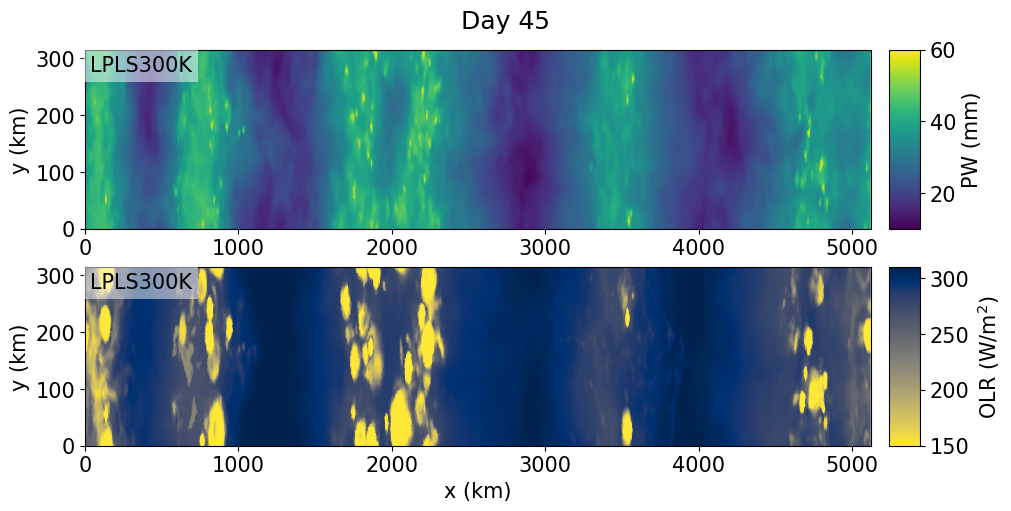

In [4]:
plot_olr_wvp("LPLS300K", "dpscream_rce_large_3km_LPLS_300K", save_dir="../plots/paperdraft/")

## Figure 3: Sensitivity study: PW var over time

In [3]:
runs = ["dpscream_rce_large_3km_Cooper_300K", "dpscream_rce_large_3km_LP05_300K",
        "dpscream_rce_large_3km_CoopLS_300K", "dpscream_rce_large_3km_LPLS_300K"]
run_names = ["Default300K","LP05300K","LSascent300K","LPLS300K"]

... getting files
/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_Cooper_300K/run/dpscream_rce_large_3km_Cooper_300K.eam.h1.2000-01-01-00000.nc
2000-01-01 00:00:00 2000-01-01 06:00:00 301 nsteps and  75 days
	Day 40? True
[########################################] | 100% Completed | 527.47 ms
[########################################] | 100% Completed | 121.75 ms
(301,) (301,)
[########################################] | 100% Completed | 218.66 ms
... getting files
/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_LP05_300K/run/dpscream_rce_large_3km_LP05_300K.eam.h1.2000-01-01-00000.nc
2000-01-01 00:00:00 2000-01-01 06:00:00 221 nsteps and  55 days
	Day 40? True
[########################################] | 100% Completed | 733.42 ms
[########################################] | 100% Completed | 132.34 ms
(221,) (221,)
[########################################] | 100% Completed | 223.80 ms
... getting files
/glade/derecho/scrat

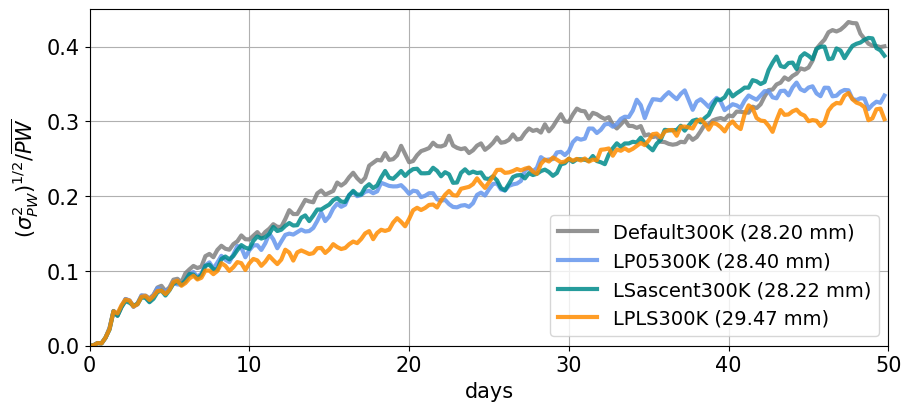

In [7]:
fig, ax1 = plt.subplots(1,1, figsize=(9,4), layout='constrained')
savename=""
for i,run in enumerate(list(runs)):
    if run[-4:].lower()=="300k":
        ls='solid'
        lw=3
        a=0.85
    elif run[-4:].lower()=="304k":
        ls='dashed'
        lw=1.5
        a=0.7
    print("... getting files")
    for x in os.listdir(f"{sims_dir}/{run}/run/"):
        file_name_start = run+".eam.h1"
        if x.startswith(file_name_start):
            file_name = f"{sims_dir}/{run}/run/{x}"
    print(file_name)
    ds = xr.open_dataset(file_name, chunks={'time':200,'ncol':2000})[['time','TMQ']]
    ndays = (ds.time[-1]-ds.time[0])
    ndays = ndays.values.astype('timedelta64[D]').astype('int')
    days = np.linspace(0,ndays,len(ds.time))
    print(ds.time[0].values, ds.time[1].values, len(ds.time),
          "nsteps and ", ndays,"days")
    # take the mean after day 40 of the simulation (mostly at equilibrium)
    # since simulations are not all the same length, shorten them to 50 days
    t40days = ds.time[0] + timedelta(days=40)
    t50days = ds.time[0] + timedelta(days=50)
    n40 = int(abs(ds.time-t40days).argmin())
    n50 = int(abs(ds.time-t50days).argmin())
    print("\tDay 40?", (t40days.values==ds.time[n40].values))
    pw_mean = ds.TMQ.mean(dim=['ncol'])
    pw_var = ds.TMQ - pw_mean  # anom
    pw_var = np.sqrt(pw_var.var(dim=['ncol']).values)  # sum(anom**2)/len(anom)
    pw_var = pw_var/pw_mean  # normalize over the mean (dimensionless)
    pw_40day_mean = ds.TMQ[n40:n50].mean(dim=['ncol','time']).values
    print(pw_var.shape, days.shape)
    del ds
    lab = run_names[i]
    savename+="_"+lab
    ax1.plot(days[:n50], pw_var[:n50], c=color_dict[run_names[i].lower()],
             linestyle=ls,
             label=f"{lab} ({pw_40day_mean:.02f} mm)",
             alpha=a, lw=lw)
    ax1.set(xlabel='days',
            ylim=[0,0.45],
            xlim=[0,50],
            ylabel='$(\sigma^2_{PW})^{1/2}/\overline{PW}$')
ax1.grid()
ax1.legend(loc=4, fontsize=14)
# ax1.legend(loc=2, fontsize=10)
savename = f"../plots/paperdraft/fig02_PW_var{savename}_sqrtpwvar_norm.pdf"
plt.savefig(savename, bbox_inches="tight", pad_inches=0.5)
print(f'saved as {savename}')
plt.show()

## Figure 4: Structure of organization

In [9]:
runs = ["dpscream_rce_large_3km_Cooper_300K",
        "dpscream_rce_large_3km_CoopLS_300K",
        "dpscream_rce_large_3km_LP05_300K",
        "dpscream_rce_large_3km_LPLS_300K"]
run_names = ["Default300K","LSascent300K","LP05300K","LPLS300K"]

0 dpscream_rce_large_3km_Cooper_300K
... getting file
/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_Cooper_300K/run/dpscream_rce_large_3km_Cooper_300K.eam.h1.2000-01-01-00000.nc
[########################################] | 100% Completed | 118.79 ms
[########################################] | 100% Completed | 125.42 ms
[########################################] | 100% Completed | 4.07 sms
[########################################] | 100% Completed | 121.78 ms
1 dpscream_rce_large_3km_CoopLS_300K
... getting file
/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_CoopLS_300K/run/dpscream_rce_large_3km_CoopLS_300K.eam.h1.2000-01-01-00000.nc
[########################################] | 100% Completed | 119.21 ms
[########################################] | 100% Completed | 119.19 ms
[########################################] | 100% Completed | 119.61 ms
[########################################] | 100% Completed | 121.90 ms
2 d

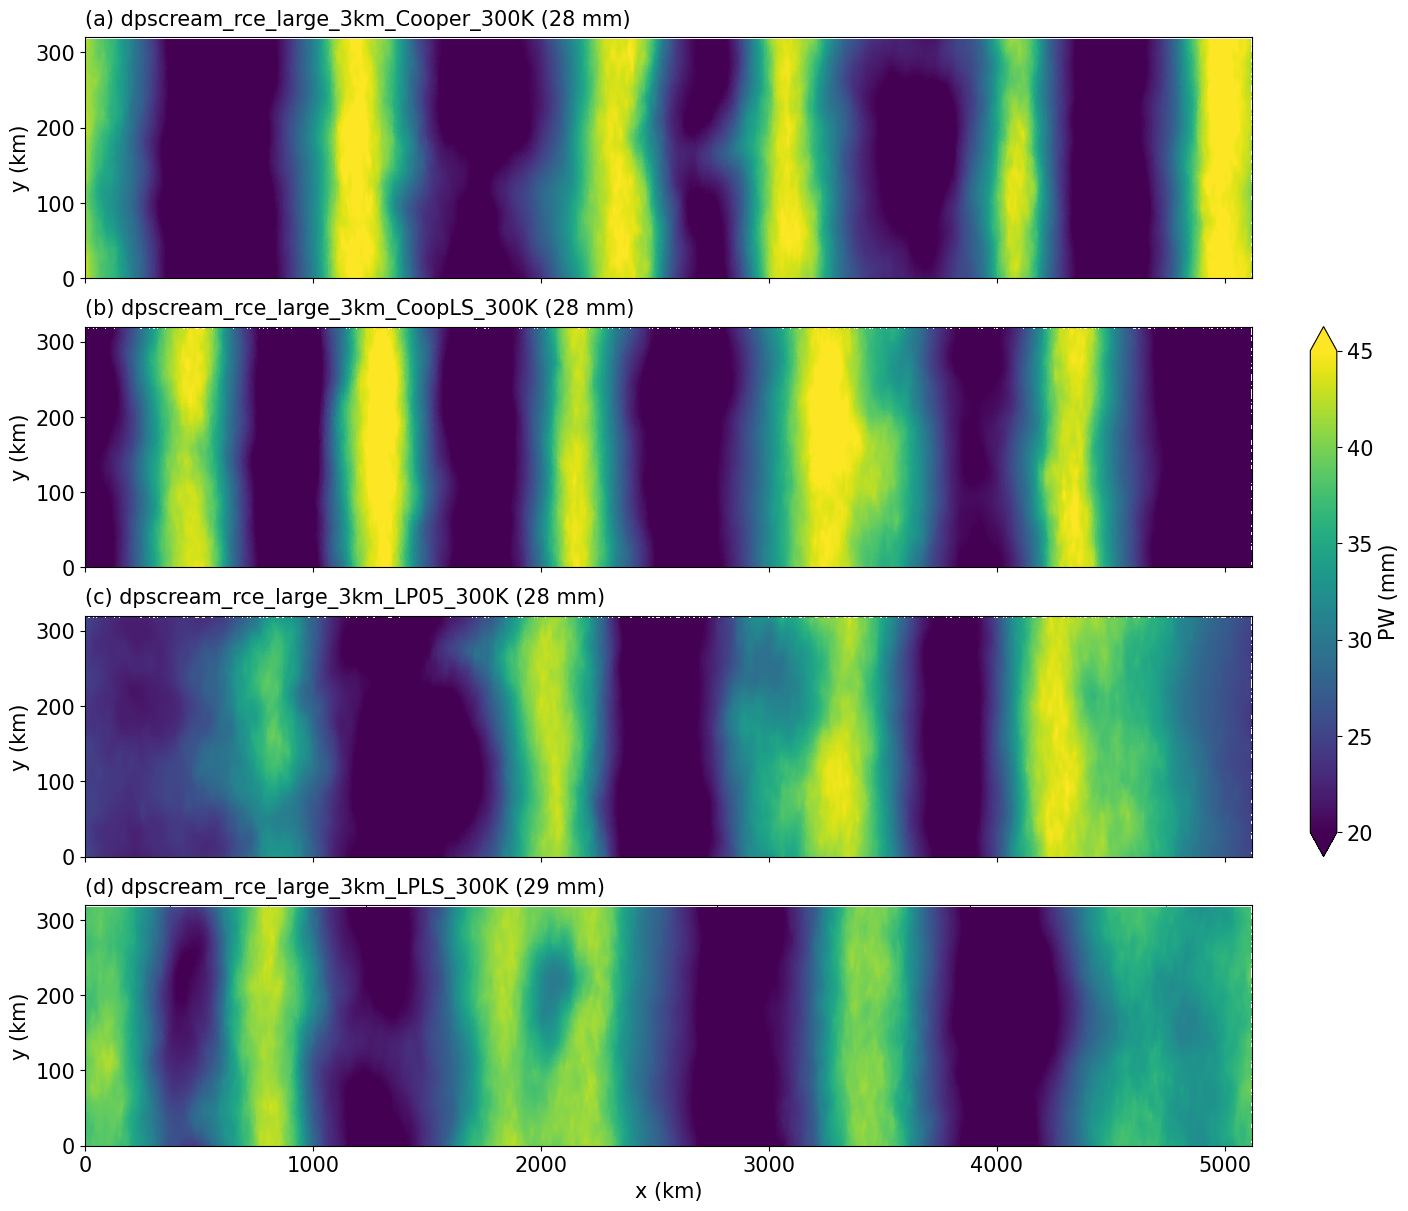

In [10]:
# zonal mean PW over the last n days of the simulation
ndays=10
fig, ax = plt.subplots(len(runs),1, figsize=(14,3*len(runs)), layout='constrained', sharex=True, sharey=True)
savename=""
for i,run in enumerate(runs):
    print(i, run)
    print("... getting file")
    for x in os.listdir(f"{sims_dir}/{run}/run/"):
        file_name_start = f"{run}.eam.h1"
        if x.startswith(file_name_start):
            file_name = f"{sims_dir}/{run}/run/"+x
    print(file_name)
    ds = xr.open_dataset(file_name, chunks={'time':200,'ncol':2000})[['time','TMQ','crm_grid_y','crm_grid_x']]
    t40days = ds.time[0] + timedelta(days=40)
    t50days = ds.time[0] + timedelta(days=50)
    n40 = int(abs(ds.time-t40days).argmin())
    n50 = int(abs(ds.time-t50days).argmin())
    ds = ds.isel(time=slice(n40,n50))
    pw_plot = ds.mean(dim=['time'])
    im = ax[i].tripcolor(pw_plot.crm_grid_y.values/1000,
                         pw_plot.crm_grid_x.values/1000,
                         pw_plot.TMQ.values,
                         cmap='viridis', vmin=20, vmax=45)
    ax[i].set(ylabel="y (km)")
    ax[i].annotate(f"({(chr(ord('`')+i+1))}) {run} ({int(ds.TMQ.mean().values)} mm)", xy=(0.0,1.05), xycoords="axes fraction")
    savename += run_names[i]


ax[-1].set(xlabel="x (km)", xlim=[0,5120], ylim=[0,320])
plt.colorbar(im, ax=ax[1:3], extend='both', label="PW (mm)")
savename = f"../plots/paperdraft/fig03_PWmean_last{ndays}days_{savename}.png"
plt.savefig(savename,bbox_inches="tight", pad_inches=0.5)
print(f"saved as {savename}")
plt.show()

## Figure 5: mhist all 300K sims

In [2]:
run_name="LSascent_300K"
run = "dpscream_rce_large_3km_CoopLS_300K"
file_name = f"{sims_dir}/{run}/run/{run}.eam.h0.2000-01-01-00000.nc"
file_mhist = file_name.split('.eam')[0]+"_mhist_rice_icnc_binned.nc"
ndays = 5  # last 10 days
file_mhist

'/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_CoopLS_300K/run/dpscream_rce_large_3km_CoopLS_300K_mhist_rice_icnc_binned.nc'

### Calculate mhist

In [3]:
var_names=["T","CLDICE","NUMICE","Q"]
ds = xr.open_dataset(file_name, chunks=chunks)[var_names]
t40days = ds.time[0] + timedelta(days=40)
t50days = t40days + timedelta(days=ndays)
n40 = int(abs(ds.time-t40days).argmin())
n50 = int(abs(ds.time-t50days).argmin())
ds = ds.isel(time=slice(n40,n50))
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
ds.CLDICE

<xarray.DataArray 'CLDICE' (time: 20, lev: 128, ncol: 147456)> Size: 2GB
dask.array<where, shape=(20, 128, 147456), dtype=float32, chunksize=(20, 128, 20000), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 160B 2000-02-10 00:00:00 ... 2000-02-14 18:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    mixing_ratio:  wet
    long_name:     Grid box averaged cloud ice amount
    cell_methods:  time: point

In [4]:
rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])

In [5]:
rice_bins=np.linspace(0,100,100)
icnc_bins=np.logspace(-5,2,70)

In [6]:
rice_flat = rice.values.flatten()

[########################################] | 100% Completed | 51.23 s


In [7]:
icnc_flat = icnc.values.flatten()

[########################################] | 100% Completed | 16.68 s


In [8]:
n = np.sum(~np.isnan(rice_flat))

In [ ]:
hist, _, _, _ = stats.binned_statistic_2d(rice_flat,
                                          icnc_flat,
                                          None,
                                          statistic='count',
                                          bins=[rice_bins, icnc_bins])
stat = 'count'

xbins = (rice_bins[1:]+rice_bins[:-1])/2
ybins = (icnc_bins[1:]+icnc_bins[:-1])/2

In [ ]:
n

In [ ]:
da = xr.DataArray(hist, dims=["rice_bins","icnc_bins"],
                  coords={"rice_bins":xbins, "icnc_bins":ybins}, 
                  attrs={'normalize by':str(n),
                         'name':'count of points with T<-40degC and qi>1e-8 for days 40-45',
                         'run_name':run_name})
ds = xr.Dataset({'hist2d':da}, attrs=da.attrs)
ds

In [13]:
if not os.path.isfile(file_mhist):
    print("saving file as", file_mhist)
    ds.to_netcdf(file_mhist)
else:
    print("file already exists, be careful before re-writing history\n",
          "- you must delete the old file if you truly want to save now:\nrm",
          file_mhist)

saving file as /glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_Cooper_300K/run/dpscream_rce_large_3km_Cooper_300K_mhist_rice_icnc_binned.nc


### Plot it


In [3]:
ds = xr.open_dataset(file_mhist)
ds

<xarray.Dataset> Size: 56kB
Dimensions:    (rice_bins: 99, icnc_bins: 69)
Coordinates:
  * rice_bins  (rice_bins) float64 792B 0.5051 1.515 2.525 ... 97.47 98.48 99.49
  * icnc_bins  (icnc_bins) float64 552B 1.132e-05 1.429e-05 ... 70.92 89.58
Data variables:
    hist2d     (rice_bins, icnc_bins) float64 55kB ...
Attributes:
    normalize by:  15109591
    name:          count of points with T<-40degC and qi>1e-8 for days 5-10 o...

In [6]:
fsmall = 1e-4 #0.01% of all points
xbins = ds.rice_bins
ybins = ds.icnc_bins
hist = ds.hist2d
n = ds.attrs['normalize by']
n = int(n)
print(n)
hist = hist/n
hist = hist.where(hist>fsmall)
n = int(n*(1-fsmall))
print(n)

15109591
15108080


plotting... 


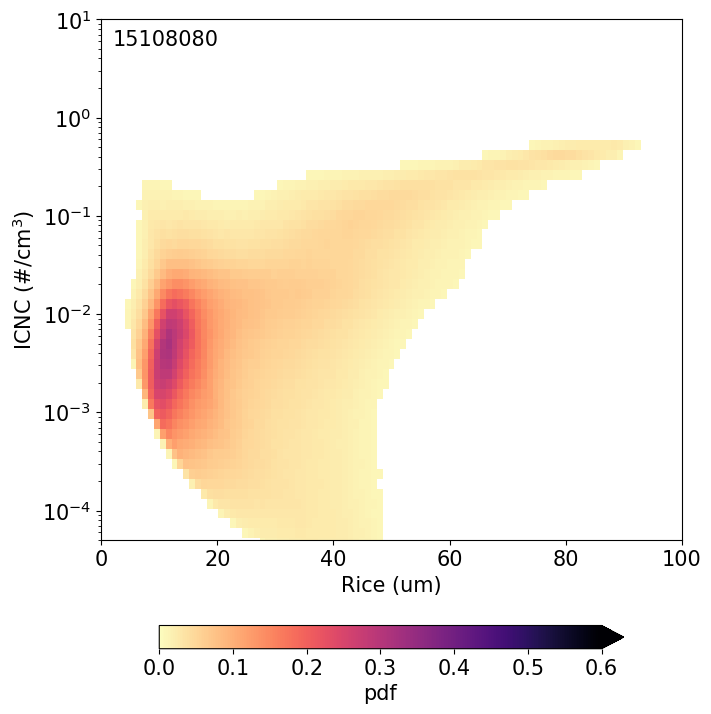

In [7]:
print("plotting... ")
fig, ax = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True)

cf = ax.pcolormesh(xbins, ybins,
                   (hist*100).T,
                   cmap="magma_r",
                   shading='auto',
                   # levels=[0,1,2,4,8,16,32,48]
                   vmin=0, vmax=0.6,  # 0.02, 0.3 std
                   # levels=np.arange(0,0.6,0.1),
                   )
plt.colorbar(cf, ax=ax, label="pdf", location="bottom", shrink=0.8, extend='max')
ax.annotate(n, xy=(0.02,0.95), xycoords="axes fraction")
ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
plt.savefig(f"../plots/paperdraft/fig_mhist_count_{run}_f{fsmall}.png")
plt.show()

### plot the difference between two runs

In [3]:
run_names=["LS ascent","LPLS"]
runs = ["dpscream_rce_large_3km_CoopLS_300K", "dpscream_rce_large_3km_LPLS_300K"]
mhist_files = [ f"{sims_dir}/{run}/run/{run}_mhist_rice_icnc_binned.nc" for run in runs ]
mhist_files

['/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_CoopLS_300K/run/dpscream_rce_large_3km_CoopLS_300K_mhist_rice_icnc_binned.nc',
 '/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_LPLS_300K/run/dpscream_rce_large_3km_LPLS_300K_mhist_rice_icnc_binned.nc']

In [4]:
ds0 = xr.open_dataset(mhist_files[0])
ds1 = xr.open_dataset(mhist_files[1])
ds0

<xarray.Dataset> Size: 56kB
Dimensions:    (rice_bins: 99, icnc_bins: 69)
Coordinates:
  * rice_bins  (rice_bins) float64 792B 0.5051 1.515 2.525 ... 97.47 98.48 99.49
  * icnc_bins  (icnc_bins) float64 552B 1.132e-05 1.429e-05 ... 70.92 89.58
Data variables:
    hist2d     (rice_bins, icnc_bins) float64 55kB ...
Attributes:
    normalize by:  25408539
    name:          count of points with T<-40degC and qi>1e-8 for days 40-45
    run_name:      LSascent_300K

total count 25408539 23162921
plotting... 


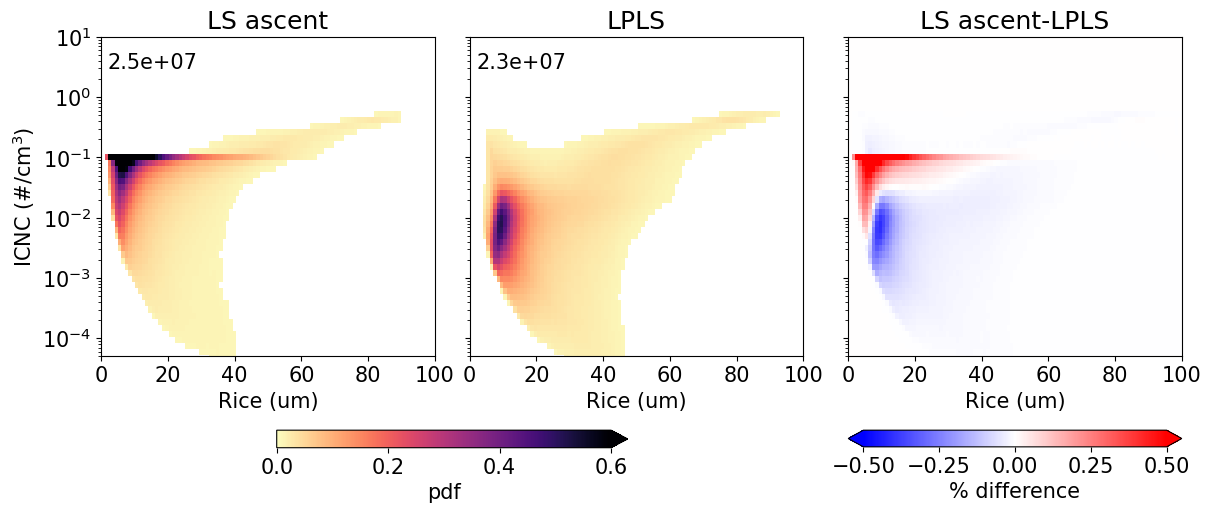

In [6]:
fsmall = 1e-4  # 0.01% of all points
fig, ax = plt.subplots(1, 3, figsize=(12,5), constrained_layout=True,
                       sharex=True, sharey=True)

xbins = ds0.rice_bins
ybins = ds0.icnc_bins
hist0 = ds0.hist2d
n0 = int(ds0.attrs['normalize by'])
hist0 = hist0/n0
hist1 = ds1.hist2d
n1 = int(ds1.attrs['normalize by'])
hist1 = hist1/n1
print("total count", n0, n1)
hist0 = np.where(np.isnan(hist0), 0, hist0)
hist1 = np.where(np.isnan(hist1), 0, hist1)
hist_diff = hist0-hist1
hist0 = np.where(hist0>fsmall, hist0, np.nan)
hist1 = np.where(hist1>fsmall, hist1, np.nan)
print("plotting... ")
cf0 = ax[0].pcolormesh(xbins, ybins,
                       (hist0*100).T,
                       cmap="magma_r",
                       shading='auto',
                       vmin=0, vmax=0.6,  # 0.02, 0.3 std
                       )
cf1 = ax[1].pcolormesh(xbins, ybins,
                       (hist1*100).T,
                       cmap="magma_r",
                       shading='auto',
                       vmin=0, vmax=0.6,  # 0.02, 0.3 std
                       )
cfd = ax[2].pcolormesh(xbins, ybins,
                       (hist_diff*100).T,
                       cmap="bwr",
                       shading='auto',
                       vmin=-0.5, vmax=0.5,  # 0.02, 0.3 std
                       )
plt.colorbar(cf0, ax=ax[0:2], label="pdf", location="bottom", shrink=0.5, extend='max')
plt.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", extend='both')
ax[0].annotate(f"{n0:0.1e}", xy=(0.02,0.9), xycoords="axes fraction")
ax[1].annotate(f"{n1:0.1e}", xy=(0.02,0.9), xycoords="axes fraction")
ax[0].set(yscale='log')
ax[0].set(xlim=[0,100], ylim=[5e-5,10])
ax[0].set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)", title=f"{run_names[0]}")
ax[1].set(xlabel="Rice (um)", title=f"{run_names[1]}")
ax[2].set(xlabel="Rice (um)", title=f"{run_names[0]}-{run_names[1]}")
plt.savefig(f"../plots/paperdraft/fig_mhist_diff_{runs[0]}-{runs[1]}_f{fsmall}.png")
plt.show()

## Figure 6: wnuc cdf (LP05 and LPLS)

Pre-processing: run the cdo_tracers2hrs.sh script for each of your simulations to get the proper files to make this plot

Then run part 1 to calculate the cdf which is saved to another file locally.

### Part 1: Calculate and save the cdf

In [86]:
run_name = "LSascent"
run="dpscream_rce_large_3km_CoopLS_300K"
file_name = f"{sims_dir}/{run}/run/{run}_h0_days40-50.nc"
var_name="W_NUC"
nuc_file = file_name.split("_h0")[0]+"_NUC_days40-50.nc"
bcu_file = file_name.split("_h0")[0]+"_BCU_days40-50.nc"
var_file = file_name.split("_h0")[0]+f"_{var_name}_days40-50.nc"
print(var_name, file_name)

W_NUC /glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_CoopLS_300K/run/dpscream_rce_large_3km_CoopLS_300K_h0_days40-50.nc


In [87]:
ice = xr.open_dataset(file_name, chunks=chunks)[["IWC","T"]].isel(lev=slice(30,80))
nuc = xr.open_dataset(nuc_file, chunks=chunks).NUC.isel(lev=slice(30,80))
bcu = xr.open_dataset(bcu_file, chunks=chunks).BCU.isel(lev=slice(30,80))
ice

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 44, lev: 50, ncol: 147456)
Coordinates:
  * time     (time) object 352B 2000-02-09 00:00:00 ... 2000-02-19 18:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol
Data variables:
    IWC      (time, lev, ncol) float32 1GB dask.array<chunksize=(44, 50, 10000), meta=np.ndarray>
    T        (time, lev, ncol) float32 1GB dask.array<chunksize=(44, 50, 10000), meta=np.ndarray>
Attributes: (12/21)
    CDI:               Climate Data Interface version 2.4.4 (https://mpimet.m...
    Conventions:       CF-1.7
    source:            E3SM Atmosphere Model
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    ne:                30
    np:                4
    ...                ...
    institution_id:    E3SM-Project
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_6
    CDO:               Climate Data Operators version 2.4.4 (https://mpimet.m...

In [88]:
# Get only the points relevant for cirrus
var = (xr.open_dataset(var_file, chunks=chunks).W_NUC*100).isel(lev=slice(30,80)) # cm/s
var = var.where((ice['T']<233.15)&(ice['IWC']>qsmall))
var = var.where((nuc<1)&(bcu>2)) # freshly nucleated detrained or insitu cirrus
var

<xarray.DataArray 'W_NUC' (time: 44, lev: 50, ncol: 147456)> Size: 1GB
dask.array<where, shape=(44, 50, 147456), dtype=float32, chunksize=(44, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 352B 2000-02-09 00:00:00 ... 2000-02-19 18:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol

In [89]:
var = var.values.flatten()

[########################################] | 100% Completed | 128.14 s
[########################################] | 100% Completed | 128.24 s
[########################################] | 100% Completed | 128.34 s


In [90]:
# calculate cdf
hist, bins = np.histogram(var, bins=np.linspace(0,20,40))
n = np.nansum(hist)
print(n)
hist = hist/n
cdf = np.cumsum(hist)
bin_mids = (bins[1:]+bins[:-1])/2


22921942


In [91]:
# save cdf to plot them all together
da = xr.DataArray(cdf, dims=['bins'], coords={'bins':bin_mids},
                  attrs={'run_name':run_name, 
                         'long_name':'normalized cdf of W_NUC from days 40-50 for all cirrus',
                         'thres':f'IWC>{qsmall} & T<-40degC & NUC<1hrs & BCU>2hrs',
                         'units':'cm/s'})
ds = xr.Dataset({'cdf':da, 'bin_edges':bins}, attrs=da.attrs)
ds

<xarray.Dataset> Size: 944B
Dimensions:    (bins: 39, bin_edges: 40)
Coordinates:
  * bins       (bins) float64 312B 0.2564 0.7692 1.282 ... 18.72 19.23 19.74
  * bin_edges  (bin_edges) float64 320B 0.0 0.5128 1.026 ... 18.97 19.49 20.0
Data variables:
    cdf        (bins) float64 312B 0.1864 0.2591 0.3221 ... 0.9915 0.9959 1.0
Attributes:
    run_name:   LSascent
    long_name:  normalized cdf of W_NUC from days 40-50 for all cirrus
    thres:      IWC>1e-08 & T<-40degC & NUC<1hrs & BCU>2hrs
    units:      cm/s

In [92]:
wnuc_cdf_file = f"../stats/wnuc_cdf_{run_name.lower().replace(" ","_")}_nuc.lt.1_bcu.gt.2.nc"
print(wnuc_cdf_file)
ds.to_netcdf(wnuc_cdf_file)
print("... saved")

../stats/wnuc_cdf_lsascent_nuc.lt.1_bcu.gt.2.nc
... saved


### Part 2: plot the saved cdfs on one figure

In [95]:
run_names = ["Default", "LSascent",
             "LP05", "LPLS"]
# run_names = [run_name.replace(" ","")]
run_names

['Default', 'LSascent', 'LP05', 'LPLS']

In [99]:
xr.open_dataset(f"../stats/wnuc_cdf_{run.lower().replace(" ","_")}_nuc.lt.1_bcu.gt.2.nc")

<xarray.Dataset> Size: 944B
Dimensions:    (bins: 39, bin_edges: 40)
Coordinates:
  * bins       (bins) float64 312B 0.2564 0.7692 1.282 ... 18.72 19.23 19.74
  * bin_edges  (bin_edges) float64 320B 0.0 0.5128 1.026 ... 18.97 19.49 20.0
Data variables:
    cdf        (bins) float64 312B ...
Attributes:
    run_name:   LPLS
    long_name:  normalized cdf of W_NUC from days 40-50 for all cirrus
    thres:      IWC>1e-08 & T<-40degC & NUC<1hrs & BCU>2hrs
    units:      cm/s

saved as ../plots/paperdraft/cdf_W_NUC_all300Ksims_freshnuc-cirrus.png


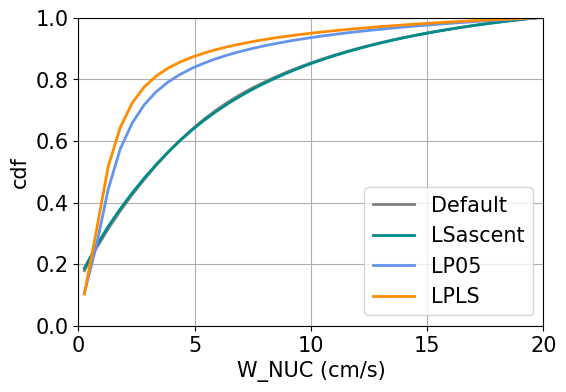

In [97]:
# plot it
fig, ax = plt.subplots(1,1, figsize=(6,4))
for i, run in enumerate(run_names):
    ds = xr.open_dataset(f"../stats/wnuc_cdf_{run.lower().replace(" ","_")}_nuc.lt.1_bcu.gt.2.nc").cdf
    ax.plot(ds.bins, ds,
    # ax.plot(bin_mids, cdf,
            lw=2, color=color_dict[run.lower().replace(" ","_")],
            label=run)
ax.set(xlabel="W_NUC (cm/s)", ylabel="cdf",
       ylim=[0,1],xlim=[0,20])
ax.grid()
ax.legend()
savename=f"../plots/paperdraft/cdf_W_NUC_all300Ksims_freshnuc-cirrus.png"
plt.savefig(savename, transparent=True, bbox_inches="tight", pad_inches=0.1)
print(f"saved as {savename}")
plt.show()

## Figure 7: vertical profiles of heating


In [3]:
run = "dpscream_rce_large_3km_LPLS_300K"
ds_file = f"{sims_dir}/{run}/run/{run}_h0_days40-50.nc"
z_file = f"{sims_dir}/{run}/run/{run}_Z3_mean.nc"
mask_file = f"{sims_dir}/{run}/run/{run}_mask_slow_fast_updraft.nc"
ice = xr.open_dataset(ds_file, chunks=chunks)[["IWC","T","QRS","QRL"]].isel(lev=slice(30,80))
z = xr.open_dataset(z_file).Z3[0,:,0,0].isel(lev=slice(30,80)).values
print(run)

dpscream_rce_large_3km_LPLS_300K


### Part 1: calculate slow/fast updraft in situ cirrus masks

Needs about 8BG of memory

In [4]:
nuc_file = f"{sims_dir}/{run}/run/{run}_NUC_days40-50.nc"
bcu_file = f"{sims_dir}/{run}/run/{run}_BCU_days40-50.nc"
wnuc_file = f"{sims_dir}/{run}/run/{run}_W_NUC_days40-50.nc"
print(wnuc_file)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_LPLS_300K/run/dpscream_rce_large_3km_LPLS_300K_W_NUC_days40-50.nc


In [5]:
nuc = xr.open_dataset(nuc_file, chunks=chunks).NUC.isel(lev=slice(30,80))
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
nuc

<xarray.DataArray 'NUC' (time: 44, lev: 50, ncol: 147456)> Size: 1GB
dask.array<where, shape=(44, 50, 147456), dtype=float32, chunksize=(44, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 352B 2000-02-09 00:00:00 ... 2000-02-19 18:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [6]:
bcu = xr.open_dataset(bcu_file, chunks=chunks).BCU.isel(lev=slice(30,80))
wnuc = xr.open_dataset(wnuc_file, chunks=chunks).W_NUC.isel(lev=slice(30,80))
insitu_slow_mask = np.where((nuc<bcu)&(bcu>30)&(wnuc<0.01), 1, 0)
insitu_fast_mask = np.where((nuc<bcu)&(bcu>30)&(wnuc>=0.1), 1, 0)
n_slow = np.nansum(insitu_slow_mask)
n_fast = np.nansum(insitu_fast_mask)
print("masks calculated.", n_slow, n_fast)
bcu

[########################################] | 100% Completed | 110.95 s
[########################################] | 100% Completed | 120.42 s
masks calculated. 2771796 98868


<xarray.DataArray 'BCU' (time: 44, lev: 50, ncol: 147456)> Size: 1GB
dask.array<getitem, shape=(44, 50, 147456), dtype=float32, chunksize=(44, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 352B 2000-02-09 00:00:00 ... 2000-02-19 18:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol
Attributes:
    long_name:     Buoyant convective updraft tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [7]:
insitu_slow_mask.shape

(44, 50, 147456)

In [8]:
da_slow = xr.DataArray(insitu_slow_mask, dims=['time','lev','ncol'], 
                       coords={'lev':ice.lev, 'time':ice.time, 'ncol':ice.ncol},
                       attrs={'n':n_slow,
                              'long_name':'mask for insitu cirrus formed via slow updraft (nuc<bcu)&(bcu>30h)&(wnuc<0.01m/s)'})
da_fast = xr.DataArray(insitu_fast_mask, dims=['time','lev','ncol'], 
                       coords={'lev':ice.lev, 'time':ice.time, 'ncol':ice.ncol},
                       attrs={'n':n_fast,
                              'long_name':'mask for insitu cirrus formed via fast updraft (nuc<bcu)&(bcu>30h)&(wnuc>0.1m/s)'})
ds_mask = xr.Dataset({'slow_updraft_mask':da_slow, 'fast_updraft_mask':da_fast}, coords=ice.coords,
                     attrs={'long_name':'masks for slow/fast updraft cirrus clouds using W_NUC', 'run':run})
ds_mask

<xarray.Dataset> Size: 5GB
Dimensions:            (lev: 50, time: 44, ncol: 147456)
Coordinates:
  * lev                (lev) float64 400B 82.6 86.04 89.38 ... 494.9 514.4 534.3
  * time               (time) object 352B 2000-02-09 00:00:00 ... 2000-02-19 ...
  * ncol               (ncol) int64 1MB 0 1 2 3 ... 147452 147453 147454 147455
Data variables:
    slow_updraft_mask  (time, lev, ncol) int64 3GB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    fast_updraft_mask  (time, lev, ncol) int64 3GB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    long_name:  masks for slow/fast updraft cirrus clouds using W_NUC
    run:        dpscream_rce_large_3km_LPLS_300K

In [9]:
mask_file

'/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_LPLS_300K/run/dpscream_rce_large_3km_LPLS_300K_mask_slow_fast_updraft.nc'

In [10]:
ds_mask.to_netcdf(mask_file)

### Part 2 calculate heating rates from mask

In [3]:
ds_mask = xr.open_dataset(mask_file, chunks=chunks)
insitu_slow_mask = ds_mask.slow_updraft_mask
insitu_fast_mask = ds_mask.fast_updraft_mask

In [4]:
insitu_slow_profile = np.nanmean(insitu_slow_mask, axis=(0,2))  # slow updraft insitu
insitu_fast_profile = np.nanmean(insitu_fast_mask, axis=(0,2))  # fast updraft insitu
print("fraction (profile) calculated.", insitu_slow_profile.shape, insitu_fast_profile.shape)

[########################################] | 100% Completed | 4.83 sms
[########################################] | 100% Completed | 3.07 sms
fraction (profile) calculated. (50,) (50,)


In [5]:
heating_lw_slow = ice["QRL"].where(insitu_slow_mask).mean(dim=['time','ncol'])*3600*24  # K/day
heating_lw_fast = ice["QRL"].where(insitu_fast_mask).mean(dim=['time','ncol'])*3600*24  # K/day
heating_sw_slow = ice["QRS"].where(insitu_slow_mask).mean(dim=['time','ncol'])*3600*24  # K/day
heating_sw_fast = ice["QRS"].where(insitu_fast_mask).mean(dim=['time','ncol'])*3600*24  # K/day
heating_net_slow = heating_lw_slow + heating_sw_slow
heating_net_fast = heating_lw_fast + heating_sw_fast

In [6]:
insitu_slow_profile = xr.DataArray(insitu_slow_profile, dims=['lev'], coords={'lev':ice.lev})
insitu_fast_profile = xr.DataArray(insitu_fast_profile, dims=['lev'], coords={'lev':ice.lev})

In [7]:
ds_new = xr.Dataset({"insitu_slow_frac": insitu_slow_profile, "insitu_fast_frac": insitu_fast_profile,
                    "heating_lw_slow": heating_lw_slow, "heating_lw_fast":heating_lw_fast,
                    "heating_sw_slow":heating_sw_slow, "heating_sw_fast":heating_sw_fast,
                    "heating_net_slow":heating_net_slow, "heating_net_fast":heating_net_fast,
                    "z_temp":z}, 
                   coords={"lev":ice.lev}, 
                   attrs={"run":run, "average period":"Days 40-50",
                          "long_name":"vertical heating profiles and cloud fraction for slow/fast updraft",
                          "n_slow":insitu_slow_mask.attrs['n'], "n_fast":67438})  # insitu_fast_mask.attrs['n']
ds_new

<xarray.Dataset> Size: 3kB
Dimensions:           (lev: 50, z_temp: 50)
Coordinates:
  * lev               (lev) float64 400B 82.6 86.04 89.38 ... 494.9 514.4 534.3
  * z_temp            (z_temp) float32 200B 1.729e+04 1.705e+04 ... 5.207e+03
Data variables:
    insitu_slow_frac  (lev) float64 400B 0.0 0.0 0.0 0.0002272 ... 0.0 0.0 0.0
    insitu_fast_frac  (lev) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    heating_lw_slow   (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    heating_lw_fast   (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    heating_sw_slow   (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    heating_sw_fast   (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    heating_net_slow  (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    heating_net_fast  (lev) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    run:             dpscream_rce_large_3km_LPLS_300K
    average period:  Days 40-50
    long_name:       vertical heating profiles and cloud fraction for slow/fa...
    n_slow:          2771796
    n_fast:          67438

In [8]:
ds_new.to_netcdf(f"../stats/insitu_slow_fast_updraft_frac_heating_{run}.nc")

[########################################] | 100% Completed | 102.28 s


### Part 3: Plot it

In [4]:
runs=["dpscream_rce_large_3km_LP05_300K","dpscream_rce_large_3km_LPLS_300K",
      "dpscream_rce_large_3km_Cooper_300K", "dpscream_rce_large_3km_CoopLS_300K"]
run_names=["LP05","LPLS","Default","LSascent"]

dpscream_rce_large_3km_LP05_300K
cornflowerblue
dpscream_rce_large_3km_LPLS_300K
darkorange
dpscream_rce_large_3km_Cooper_300K
gray
dpscream_rce_large_3km_CoopLS_300K
darkcyan
Days 40-50
saved as ../plots/paperdraft/fig_insitu-slow-fast-updraft-heating-rates_days40-50.png


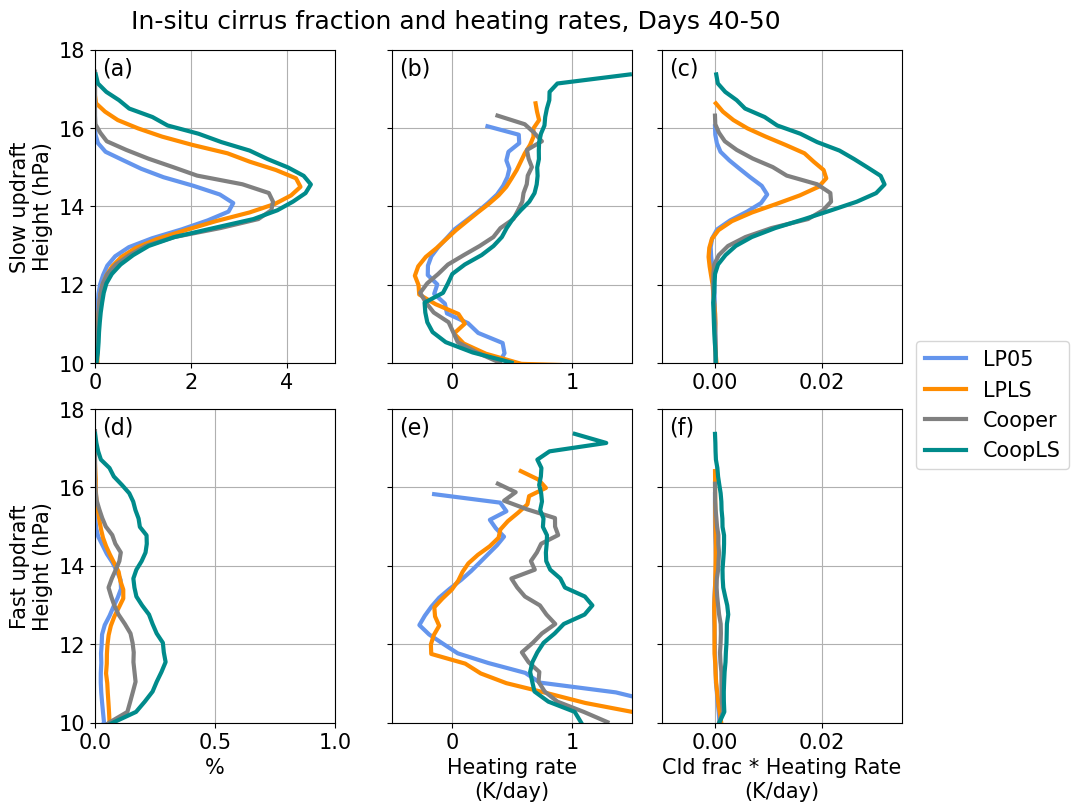

In [14]:
fig, ax = plt.subplots(2,3, figsize=(9,8), layout='constrained', sharey=True)
trop_z = 0
for i, run in enumerate(runs):
    print(run)
    run_color=color_dict[run_names[i].lower()]
    print(run_color)
    ds = xr.open_dataset(f"../stats/insitu_slow_fast_updraft_frac_heating_{run}.nc")
    z = ds.z_temp/1000
    # z = xr.open_dataset(f"{sims_dir}/{run}/run/{run}_Z3_mean.nc").Z3.isel(lev=slice(30,80))[0,:,0,0].values/1000
    if "304" in run:
        ls = "dashed"
    else:
        ls = "solid"
    trop_z = 0
    ax[0,0].plot((ds.insitu_slow_frac*100)[trop_z:], z[trop_z:], color=run_color, 
                 label=run.split("_")[-2],
                 lw=3, linestyle=ls)
    ax[1,0].plot((ds.insitu_fast_frac*100)[trop_z:], z[trop_z:], color=run_color, 
                 lw=3, linestyle=ls)
    ax[0,1].plot(ds.heating_net_slow[trop_z:], z[trop_z:], color=run_color,
                 lw=3, linestyle=ls)
    ax[0,2].plot((ds.heating_net_slow*ds.insitu_slow_frac)[trop_z:], z[trop_z:], color=run_color,
                 lw=3, linestyle=ls)
    ax[1,1].plot(ds.heating_net_fast[trop_z:], z[trop_z:], color=run_color,
                 lw=3, linestyle=ls)
    ax[1,2].plot((ds.heating_net_fast*ds.insitu_fast_frac)[trop_z:], z[trop_z:], color=run_color,
                 lw=3, linestyle=ls)
for i in range(2):
    for j in range(3):
        ax[i,j].grid(True)
ax[0,0].annotate("(a)", xy=(0.03,0.92), xycoords="axes fraction", size=16)
ax[0,1].annotate("(b)", xy=(0.03,0.92), xycoords="axes fraction", size=16)
ax[0,2].annotate("(c)", xy=(0.03,0.92), xycoords="axes fraction", size=16)
ax[1,0].annotate("(d)", xy=(0.03,0.92), xycoords="axes fraction", size=16)
ax[1,1].annotate("(e)", xy=(0.03,0.92), xycoords="axes fraction", size=16)
ax[1,2].annotate("(f)", xy=(0.03,0.92), xycoords="axes fraction", size=16)

ax[1,0].set(xlabel="%", ylabel="Fast updraft\nHeight (hPa)",
            xlim=[0,1], ylim=[10,18])
ax[0,0].set(xlim=[0,5], ylabel="Slow updraft\nHeight (hPa)")
ax[1,1].set(xlim=[-0.5,1.5], xlabel="Heating rate\n(K/day)")
ax[0,1].set(xlim=[-0.5,1.5])
ax[1,2].set(xlim=[-0.01,0.035], xlabel="Cld frac * Heating Rate\n(K/day)")
ax[0,2].set(xlim=[-0.01,0.035])
ndays = ds.attrs["average period"]
print(ndays)
fig.suptitle(f"In-situ cirrus fraction and heating rates, {ndays}")
fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
savename=f"../plots/paperdraft/fig_insitu-slow-fast-updraft-heating-rates_{ndays.lower().replace(" ","")}.png"
plt.savefig(savename, transparent=True, bbox_inches="tight", pad_inches=1)
print("saved as "+savename)
plt.show()

## Figure 8: in situ cirrus lifetime as seen through tracers


In [2]:
runs = ['dpscream_rce_large_3km_Cooper_300K','dpscream_rce_large_3km_CoopLS_300K',
        'dpscream_rce_large_3km_LP05_300K','dpscream_rce_large_3km_LPLS_300K']
run_names = ["Default", "LSascent","LP05","LPLS"]
nt=20
bins = np.arange(0,48)
bin_mids = (bins[1:]+bins[:-1])/2

Loading files for dpscream_rce_large_3km_Cooper_300K...
... NUC...
... BCU...
... other 3d variables...
[########################################] | 100% Completed | 51.58 s
14300227 total cloudy grid points with ice at cirrus temperatures
[########################################] | 100% Completed | 66.07 s
3059933 total in-cld insitu cirrus grid points at cirrus temperatures
Get histogram...
[########################################] | 100% Completed | 60.27 s
Turn into cdf (cumsum)...
print data points in cdf...
{0.5: 0.44495941577805787, 1.5: 0.6867232060309817, 2.5: 0.8005763524887637, 3.5: 0.8510781118410109, 4.5: 0.8793453974319045, 5.5: 0.8996308089098682, 6.5: 0.9167958906289778, 7.5: 0.9311187532537477, 8.5: 0.9429762024201184, 9.5: 0.9535976768118779, 10.5: 0.9623233580604542, 11.5: 0.9698179666025367, 12.5: 0.9759305187401162, 13.5: 0.9809110199471688, 14.5: 0.9849019570036337, 15.5: 0.9882448406550078, 16.5: 0.9912439259290972, 17.5: 0.9936596650972424, 18.5: 0.99552212417

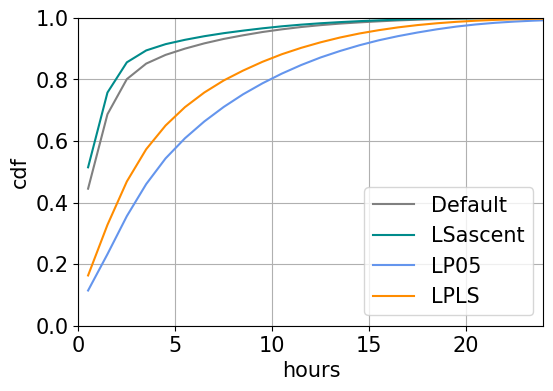

... Saved as ../plots/paperdraft/tracers_cdf_insitu_only_all300Ksims.png
Done.


<xarray.Dataset> Size: 2kB
Dimensions:   (bins: 47)
Coordinates:
  * bins      (bins) float64 376B 0.5 1.5 2.5 3.5 4.5 ... 43.5 44.5 45.5 46.5
Data variables:
    default   (bins) float64 376B 0.445 0.6867 0.8006 0.8511 ... 1.0 1.0 1.0 1.0
    lsascent  (bins) float64 376B 0.5143 0.757 0.8552 0.8938 ... 1.0 1.0 1.0 1.0
    lp05      (bins) float64 376B 0.1143 0.2324 0.3559 0.4599 ... 1.0 1.0 1.0
    lpls      (bins) float64 376B 0.1632 0.3276 0.4683 0.5732 ... 1.0 1.0 1.0
Attributes:
    long_name:  cdf of NUC aka in situ cirrus lifetime
    nt:         20

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

for i, run in enumerate(runs):

    ice_file = f'{sims_dir}/{run}/run/{run}_h0_days40-50.nc'
    bcu_file = f'{sims_dir}/{run}/run/{run}_BCU_days40-50.nc'
    nuc_file = f'{sims_dir}/{run}/run/{run}_NUC_days40-50.nc'

    print(f'Loading files for {run}...')
    print('... NUC...')
    nuc_ds = xr.open_dataset(nuc_file, chunks=chunks).NUC.isel(time=slice(-nt,-1)).isel(lev=slice(30,80))
    print('... BCU...')
    bcu_ds = xr.open_dataset(bcu_file, chunks=chunks).BCU.isel(time=slice(-nt,-1)).isel(lev=slice(30,80))
    print('... other 3d variables...')
    ice_ds = xr.open_dataset(ice_file, chunks=chunks)[['IWC','T']].isel(time=slice(-nt,-1)).isel(lev=slice(30,80))
    mask = (ice_ds.IWC>qsmall)&(ice_ds['T']<233.15)
    nuc_ds = nuc_ds.where(mask)
    bcu_ds = bcu_ds.where(mask)
    n = np.nansum(mask)
    print(n, 'total cloudy grid points with ice at cirrus temperatures')
    mask = (mask & (bcu_ds>24) & (nuc_ds<bcu_ds-5))
    ins_ci = nuc_ds.where(mask)
    n_ins = np.nansum(mask)
    print(n_ins, 'total in-cld insitu cirrus grid points at cirrus temperatures')

    print('Get histogram...')
    ins_hist, _ = np.histogram(ins_ci.values.flatten(), bins=bins)

    print('Turn into cdf (cumsum)...')
    ins_cdf = np.cumsum(ins_hist)/n_ins

    print('print data points in cdf...')
    print(dict(zip(bin_mids, ins_cdf)))
    da = xr.DataArray(ins_cdf, dims=["bins"], coords={'bins':bin_mids},
                      attrs={'long_name':'cdf of NUC aka in situ cirrus lifetime',
                             'run':run, 'nt':nt})

    print('Plotting...')
    run_label=run_names[i]
    print(run_label)
    ax.plot(bin_mids, ins_cdf, label=f'{run_label}',
            color=color_dict[run_label.lower()])
    if i==0:
        ds = xr.Dataset({run_names[i].lower():da},
                        attrs={'long_name':'cdf of NUC aka in situ cirrus lifetime',
                               'nt':nt}
                       )
    else:
        ds = ds.assign({run_names[i].lower():da})

ax.set(xlabel='hours', ylabel='cdf', ylim=[0,1], xlim=[0,24])
ax.grid(True)
ax.legend(loc=4)
savename=f'../plots/paperdraft/tracers_cdf_insitu_only_all300Ksims.png'
plt.savefig(savename, dpi=150, transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()
print(f'... Saved as {savename}\nDone.')
ds

In [7]:
ds.to_netcdf(f'../stats/cdf_NUC_insitucilifetime_{nt}.nc')

------------
# Part 2:  A case study using LPLS

In [2]:
run_name="LPLS"
run = "dpscream_rce_large_3km_LPLS_300K"
file_name = f"{sims_dir}/{run}/run/{run}_h0_days40-50.nc"
run

'dpscream_rce_large_3km_LPLS_300K'

## Figure 1: Vertical cross section 

In [13]:
run_file = f"{sims_dir}/{run}/run/{run}.eam.h0.2000-01-01-00000.nc"
tday=51
vars=['time','crm_grid_x','crm_grid_y',
      'CLDICE','CLDLIQ','T','TMQ','Z3',
      'NUC','BCU','OMEGA','NUMICE','Q',
      'QRL','QRS','NI_NUC'
      # 'P3_hom_frz_ni_tend','P3_lp05_hom_ni_tend', 'P3_ni_nucleat_tend'
     ]

ds = xr.open_dataset(run_file)[vars]
t_snap =  ds.time[0] + timedelta(days=tday)
print("RUN:", run_name, file_name, "\n... plotting snapshot at day", tday, t_snap.values)
ds = ds.sel(time=t_snap, method="nearest")
# ds.TMQ

RUN: LPLS /glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_LPLS_300K/run/dpscream_rce_large_3km_LPLS_300K_h0_days40-50.nc 
... plotting snapshot at day 51 2000-02-21 00:00:00


In [14]:
ds = ds.set_coords(['crm_grid_y','crm_grid_x'])
ds

<xarray.Dataset> Size: 908MB
Dimensions:     (ncol: 147456, lev: 128)
Coordinates:
    time        object 8B 2000-02-21 00:00:00
    crm_grid_x  (ncol) float32 590kB ...
    crm_grid_y  (ncol) float32 590kB ...
  * lev         (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 991.0 994.9 998.5
Dimensions without coordinates: ncol
Data variables: (12/13)
    CLDICE      (lev, ncol) float32 75MB ...
    CLDLIQ      (lev, ncol) float32 75MB ...
    T           (lev, ncol) float32 75MB ...
    TMQ         (ncol) float32 590kB ...
    Z3          (lev, ncol) float32 75MB ...
    NUC         (lev, ncol) float32 75MB ...
    ...          ...
    OMEGA       (lev, ncol) float32 75MB ...
    NUMICE      (lev, ncol) float32 75MB ...
    Q           (lev, ncol) float32 75MB ...
    QRL         (lev, ncol) float32 75MB ...
    QRS         (lev, ncol) float32 75MB ...
    NI_NUC      (lev, ncol) float32 75MB ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         97c6f525aa
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_6

In [15]:
z = ds.Z3.mean(dim=['ncol'])/1000
cross_mask = np.where(ds.crm_grid_x < 10, 1, 0)

In [16]:
iwc_plot = (ds.CLDICE+ds.CLDLIQ).where(cross_mask[np.newaxis,:])
iwc_plot = iwc_plot.groupby(ds.crm_grid_y).mean()
iwc_plot

<xarray.DataArray (lev: 128, crm_grid_y: 1536)> Size: 786kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time        object 8B 2000-02-21 00:00:00
  * lev         (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 991.0 994.9 998.5
  * crm_grid_y  (crm_grid_y) float32 6kB 0.0 2.764e+03 ... 5.113e+06 5.117e+06

In [17]:
pw_plot = ds.TMQ.groupby(ds.crm_grid_y).mean()
pw_plot

<xarray.DataArray 'TMQ' (crm_grid_y: 1536)> Size: 6kB
array([33.905815, 33.965416, 34.057747, ..., 33.799156, 33.806732,
       33.855274], dtype=float32)
Coordinates:
    time        object 8B 2000-02-21 00:00:00
  * crm_grid_y  (crm_grid_y) float32 6kB 0.0 2.764e+03 ... 5.113e+06 5.117e+06
Attributes:
    units:          kg/m2
    long_name:      Total (vertically integrated) precipitable water
    standard_name:  atmosphere_mass_content_of_water_vapor
    cell_methods:   time: point

In [54]:
nuc_plot = -np.log(ds.NUC).where(cross_mask[np.newaxis,:])
nuc_plot = nuc_plot.groupby(ds.crm_grid_y).mean().where(iwc_plot>qsmall)
bcu_plot = -np.log(ds.BCU).where(cross_mask[np.newaxis,:])
bcu_plot = bcu_plot.groupby(ds.crm_grid_y).mean().where(iwc_plot>qsmall)

# nuc_plot = (ds.P3_hom_frz_ni_tend+ds.P3_lp05_hom_ni_tend).where(cross_mask[np.newaxis, :])
# nuc_plot = nuc_plot.groupby(ds.crm_grid_y).mean().where(iwc_plot>qsmall)
# bcu_plot = ds.P3_ni_nucleat_tend.where(cross_mask[np.newaxis, :])
# bcu_plot = bcu_plot.groupby(ds.crm_grid_y).mean().where(iwc_plot>qsmall)

w = util.omega2w(ds.OMEGA, ds.lev*100, ds['T'])
w_plot = w.where(cross_mask[np.newaxis, :])
w_plot = w_plot.groupby(ds.crm_grid_y).mean()#.where(iwc_plot>qsmall)

qrl_plot = (ds.QRL-ds.QRS).where(cross_mask[np.newaxis, :])
qrl_plot = (qrl_plot*3600*24).groupby(ds.crm_grid_y).mean()#.where(iwc_plot>qsmall)

icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])
icnc_plot = icnc.where(cross_mask[np.newaxis, :])
icnc_plot = icnc_plot.groupby(ds.crm_grid_y).mean()#.where(iwc_plot>qsmall)

rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
rice_plot = rice.where(cross_mask[np.newaxis, :])
rice_plot = rice_plot.groupby(ds.crm_grid_y).mean()#.where(iwc_plot>qsmall)

# rice_plot = util.calc_ni(ds.NI_NUC/ds.NUC, ds.Q, ds.lev*100, ds['T']).where(cross_mask[np.newaxis, :])
# rice_plot = rice_plot.groupby(ds.crm_grid_y).mean()#.where(iwc_plot>qsmall)


ta_plot = ds['T'].where((cross_mask[np.newaxis,:]))
ta_plot = ta_plot.groupby(ds.crm_grid_y).mean()
ta_plot = ta_plot.where(ta_plot.lev>80).values
print(ta_plot.shape)
z40ind = np.nanargmin(abs(ta_plot-233.15), axis=0)
print(z40ind.shape)
z40 = np.array([z.isel(lev=z40ind[i]) for i in range(len(z40ind))])
print(z40.shape, z40[0])

(128, 1536)
(1536,)
(1536,) 9.727362


In [55]:
def ax_contourf_xsection(var_plot, z_plot, ax, cax, levs=None, units=None, 
                         log_scale=False, label_subplot=None, **kwargs):
    if log_scale:
        var_plot = np.log10(var_plot)
        units=f"log10({units})"
    if levs is None:
        raise Exception("Include levels for plotting with pyplot.contour (levs=???)")
    cf = ax.contourf(var_plot.crm_grid_y.values/1000,
                     z_plot,
                     var_plot,
                     levels=levs,
                     **kwargs
                     )
    ax.set(ylim=[0,20], ylabel="z (km)")
    ax.grid(True)
    # ax.set_axisbelow(True)
    plt.colorbar(cf, cax=cax, label=units)
    if label_subplot is not None:
        ax.annotate(label_subplot, xy=(0.01,0.9), xycoords="axes fraction")
    return ax, cax

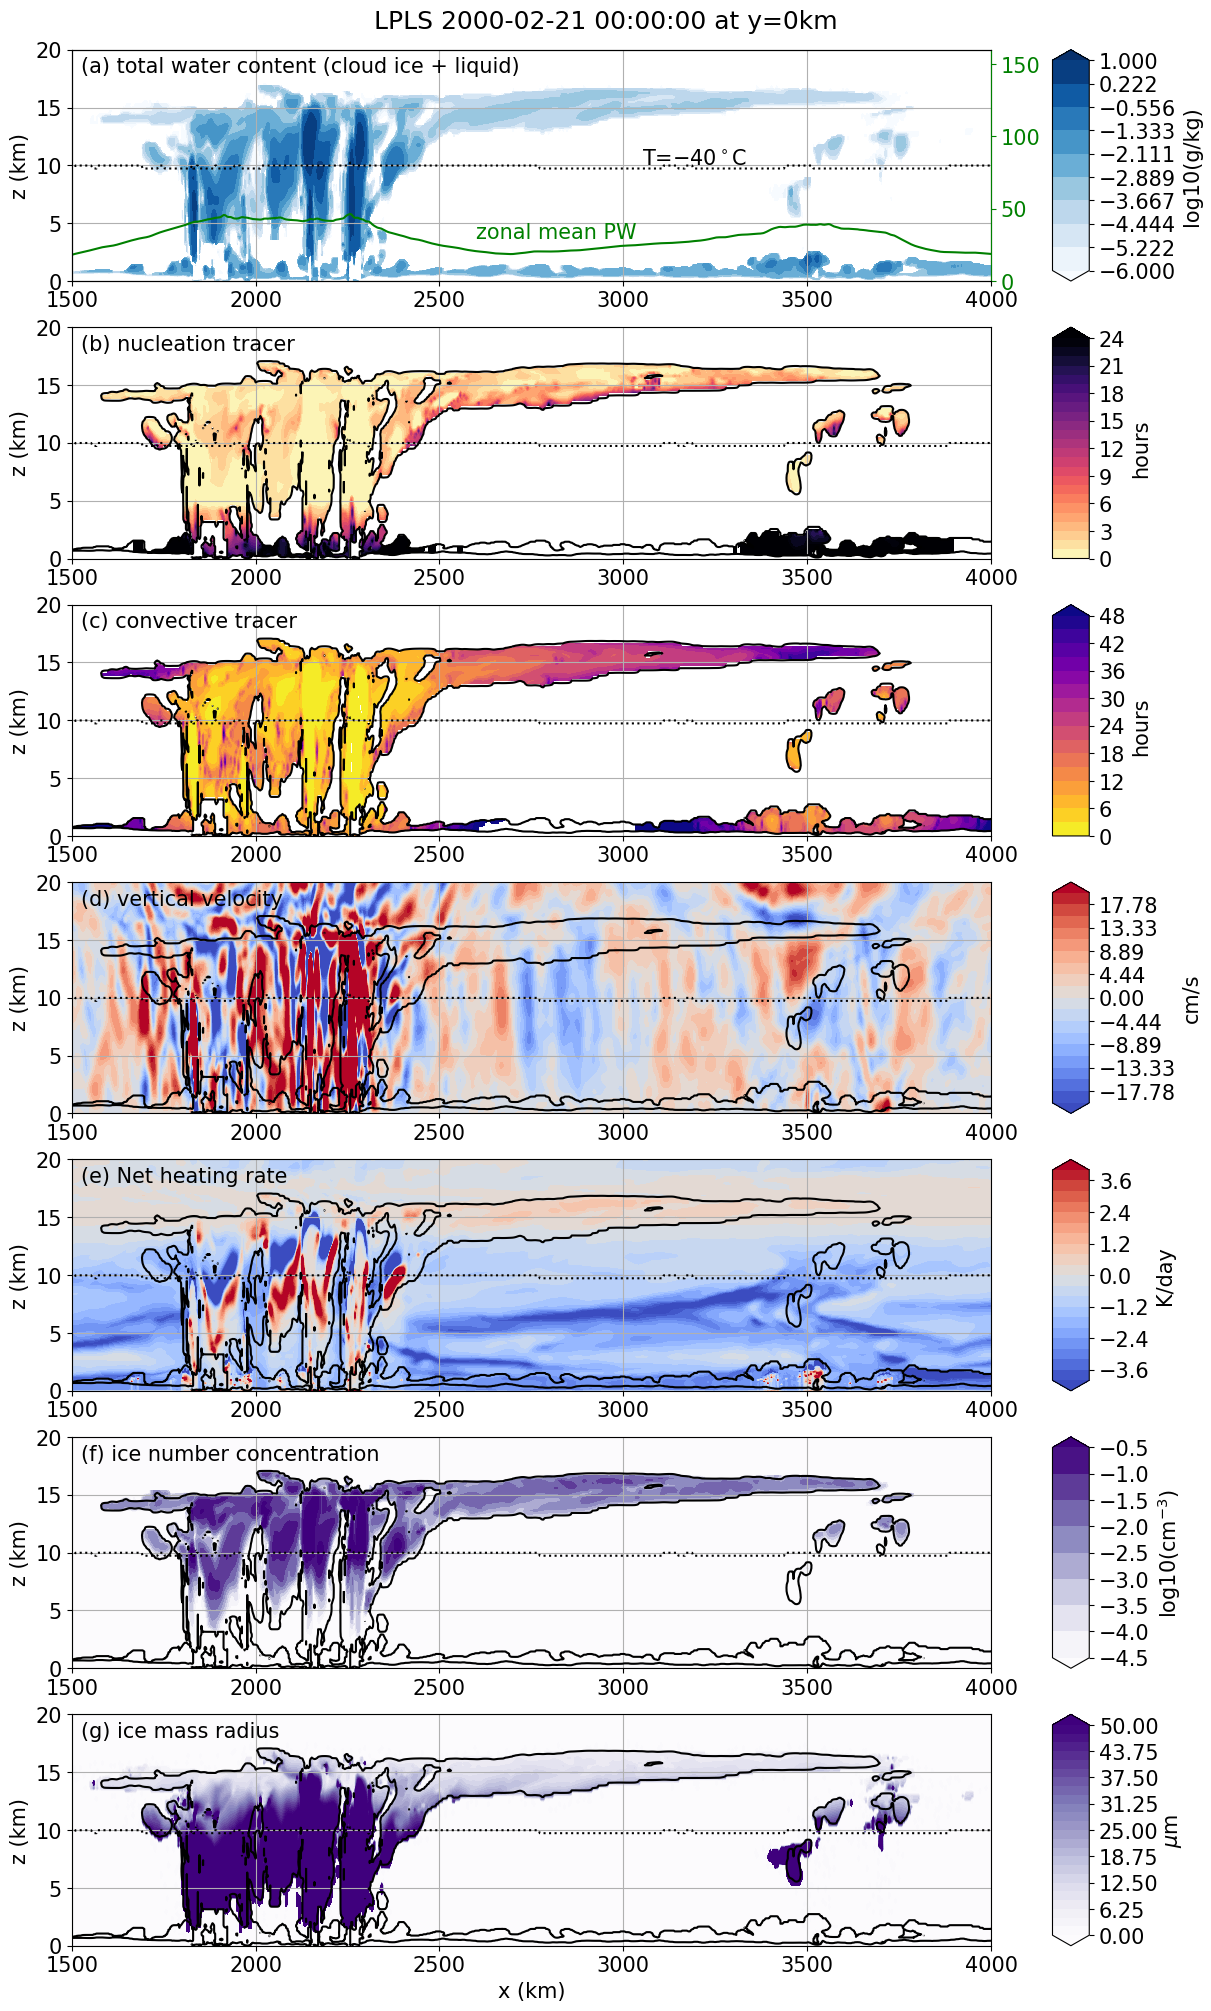

In [56]:
fig = plt.figure(figsize=(12, 20), layout="constrained")
gs = GridSpec(7, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
ax0, cax0 = ax_contourf_xsection(iwc_plot*1000, z, ax=ax0, cax=cax0,
                                 log_scale=True, units="g/kg",
                                 levs=np.linspace(-6, 1, 10),
                                 cmap="Blues", extend="both",
                                 label_subplot="(a) total water content (cloud ice + liquid)")
ax0t = ax0.twinx()
ax0t.plot(pw_plot.crm_grid_y.values/1000, pw_plot.values, 'green')
ax0t.set(ylim=[0,160])
ax0t.spines['right'].set_color('green')
ax0t.tick_params(axis='y', colors='green')

ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
ax1, cax1 = ax_contourf_xsection(nuc_plot, z, ax=ax1, cax=cax1,
                                 units="hours", levs=np.arange(0,25,1),
                                 # units="kg/kg/s", levs=nuc_levs,
                                 extend="max",cmap="magma_r",
                                 label_subplot="(b) nucleation tracer")
                                 # label_subplot="(b) nucleation tendency from HOM")
ax1.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')

ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
ax2, cax2 = ax_contourf_xsection(bcu_plot, z, ax=ax2, cax=cax2,
                                 units="hours", levs=np.arange(0,49,3),
                                 # units="kg/kg/s", levs=nuc_levs,
                                 extend="max",cmap="plasma_r",
                                 label_subplot="(c) convective tracer")
                                 # label_subplot="(c) total nucleation tendency")
ax2.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')

ax3 = fig.add_subplot(gs[3, 0])
cax3 = fig.add_subplot(gs[3, 1])
ax3, cax3 = ax_contourf_xsection(w_plot*100, z, ax=ax3, cax=cax3,
                                 units="cm/s", levs=np.linspace(-20, 20, 19),
                                 extend="both",cmap="coolwarm",
                                 label_subplot="(d) vertical velocity")
ax3.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')

ax4 = fig.add_subplot(gs[4, 0])
cax4 = fig.add_subplot(gs[4, 1])
ax4, cax4 = ax_contourf_xsection(qrl_plot, z, ax=ax4, cax=cax4,
                                 units="K/day", log_scale=False,
                                 levs=np.linspace(-4,4,21),
                                 extend="both",cmap="coolwarm",
                                 label_subplot="(e) Net heating rate")
ax4.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')

ax5 = fig.add_subplot(gs[5, 0])
cax5 = fig.add_subplot(gs[5, 1])
ax5, cax5 = ax_contourf_xsection(icnc_plot, z, ax=ax5, cax=cax5,
                                 units="cm$^{-3}$", log_scale=True,
                                 levs=np.arange(-4.5,-0.49,0.5),
                                 extend="both",cmap="Purples",
                                 label_subplot="(f) ice number concentration")
ax5.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')

ax6 = fig.add_subplot(gs[6, 0])
cax6 = fig.add_subplot(gs[6, 1])
ax6, cax6 = ax_contourf_xsection(rice_plot, z, ax=ax6, cax=cax6,
                                 units="$\mu$m",
                                 # units="1/kg/s", log_scale=True,
                                 # levs=np.linspace(-4.5,-0.5,20),
                                 levs=np.linspace(0,50,25),
                                 extend="both",cmap="Purples",
                                 label_subplot="(g) ice mass radius")
                                 # label_subplot="(g) ICNC at nucleation")
ax6.contour(iwc_plot.crm_grid_y.values/1000, z, iwc_plot, levels=[1e-8], colors='k')
ax6.set(xlabel="x (km)")

for ax in [ax0,ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set(xlim=[1500,4000])
ax0.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax1.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax2.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax3.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax4.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax5.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax6.plot(iwc_plot.crm_grid_y.values/1000, z40, linestyle='dotted', color='k')
ax0.annotate("T=$-40^\circ$C", xy=(3050, 10.1), xycoords="data")  # xy=(3850, 10)
ax0.annotate("zonal mean PW", xy=(2600,3.7),xycoords='data', color='green') 
fig.suptitle(f"{run_name} {ds.time.values} at y=0km")
plt.savefig(f"../plots/paperdraft/fig02_xsection_{run_name}_day{tday}_zoomed.pdf")
plt.show()

## Figure 2: mphys tracer evolution

In [2]:
nt=20
tracer="BCU"
time_period = 3  # 0: 0-1 hrs, 1: 3-4 hrs, 2: 7-8 hrs, 3: >30hrs
mhist_stat_file = f"../stats/mhist2d_rice-icnc-{tracer.lower()}_{run}.nc"
if os.path.isfile(mhist_stat_file):
    xr.open_dataset(mhist_stat_file)

NameError: name 'run' is not defined

### Part 1: calculate the tracer mhist evolution in time per each tracer separately

In [9]:
# select time period
if time_period==0:
    tracer_low_thres=0
    tracer_hgh_thres=1
elif time_period==1:
    tracer_low_thres=3
    tracer_hgh_thres=4
elif time_period==2:
    tracer_low_thres=7
    tracer_hgh_thres=8
elif time_period==3:
    tracer_low_thres=30
    tracer_hgh_thres=100  # super high to include all points above 30 hrs
else:
    raise Exception(f"time_period = {time_period} not defined try\n0 (0-1 hrs), 1 (3-4 hrs), 2 (7-8 hrs), or 3 (>30 hrs)")
print(f"tracer {tracer} between {tracer_low_thres} and {tracer_hgh_thres} hrs")

tracer BCU between 30 and 100 hrs


In [10]:
ds = xr.open_dataset(file_name, chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))[['IWC','T','NUMICE','Q', 'CLDICE']]
print(tracer)
if tracer=="NUC":
    tracer_ds = xr.open_dataset(file_name.replace("h0","NUC"), chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))['NUC']
elif tracer=="BCU":
    tracer_ds = xr.open_dataset(file_name.replace("h0","BCU"), chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))['BCU']
else:
    raise Exception(f"tracer {tracer} not defined, try NUC or BCU")
tracer_ds

BCU


<xarray.DataArray 'BCU' (time: 19, lev: 50, ncol: 147456)> Size: 560MB
dask.array<getitem, shape=(19, 50, 147456), dtype=float32, chunksize=(19, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 152B 2000-02-15 00:00:00 ... 2000-02-19 12:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol
Attributes:
    long_name:     Buoyant convective updraft tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [11]:
# filter
mask = ((ds['IWC']>qsmall)&(ds['T']<233.15)&(tracer_ds>=tracer_low_thres)&(tracer_ds<tracer_hgh_thres))
print(f"tracer between {tracer_low_thres} and {tracer_hgh_thres} hours")
ds = ds.where(mask)

tracer between 30 and 100 hours


In [12]:
icnc = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])

In [13]:
rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
rice

<xarray.DataArray (time: 19, lev: 50, ncol: 147456)> Size: 560MB
dask.array<mul, shape=(19, 50, 147456), dtype=float32, chunksize=(19, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 152B 2000-02-15 00:00:00 ... 2000-02-19 12:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol

In [14]:
# flatten arrays for 2D hist
print("flattening...")
icnc_flat = icnc.values.flatten()
print("icnc done...")
rice_flat = rice.values.flatten()
print("rice done...")

flattening...
[########################################] | 100% Completed | 140.05 s
icnc done...
[########################################] | 100% Completed | 161.03 s
rice done...


In [15]:
len(icnc_flat)

140083200

In [16]:
icnc_flat = icnc_flat[~np.isnan(rice_flat)]
rice_flat = rice_flat[~np.isnan(rice_flat)]

In [17]:
n = len(icnc_flat)
n

2058657

In [18]:
xbins = np.linspace(0,100,80)
ybins = np.logspace(-5,2,70)
print("calculating hist 2D...")
hist, _, _ = np.histogram2d(rice_flat, icnc_flat, bins=[xbins,ybins])
print("... hist done.")

calculating hist 2D...
... hist done.


In [19]:
xbin_mids = (xbins[1:]+xbins[:-1])/2
ybin_mids = (ybins[1:]+ybins[:-1])/2

In [20]:
# save to netcdf
da = xr.DataArray(hist, dims=['rice_bins','icnc_bins'],
                  coords={'rice_bins':xbin_mids,
                          'icnc_bins':ybin_mids},
                  attrs={'long_name':f'histogram (count) of rice vs icnc for {tracer} between {tracer_low_thres} and {tracer_hgh_thres} hrs',
                         'run':run, 'n':int(n)})
if os.path.isfile(mhist_stat_file):
    ds = xr.open_dataset(mhist_stat_file)
    ds = ds.assign({f"{tracer}_{time_period}":da})
else:
    ds = xr.Dataset({f"{tracer}_{time_period}":da},
                    coords=da.coords,
                    attrs={'long_name':f'histogram (count) of rice vs icnc for {tracer} for different time periods',
                           'run':run, 'number of timesteps':nt}
                   )
ds

<xarray.Dataset> Size: 176kB
Dimensions:    (rice_bins: 79, icnc_bins: 69)
Coordinates:
  * rice_bins  (rice_bins) float64 632B 0.6329 1.899 3.165 ... 96.84 98.1 99.37
  * icnc_bins  (icnc_bins) float64 552B 1.132e-05 1.429e-05 ... 70.92 89.58
Data variables:
    BCU_0      (rice_bins, icnc_bins) float64 44kB ...
    BCU_1      (rice_bins, icnc_bins) float64 44kB ...
    BCU_2      (rice_bins, icnc_bins) float64 44kB ...
    BCU_3      (rice_bins, icnc_bins) float64 44kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    long_name:            histogram (count) of rice vs icnc for BCU for diffe...
    run:                  dpscream_rce_large_3km_LPLS_300K
    number of timesteps:  20

In [21]:
if os.path.isfile(mhist_stat_file):
    !rm {mhist_stat_file}
ds.to_netcdf(mhist_stat_file)

### Part 2: open the dataset for each tracer histogram and plot it!




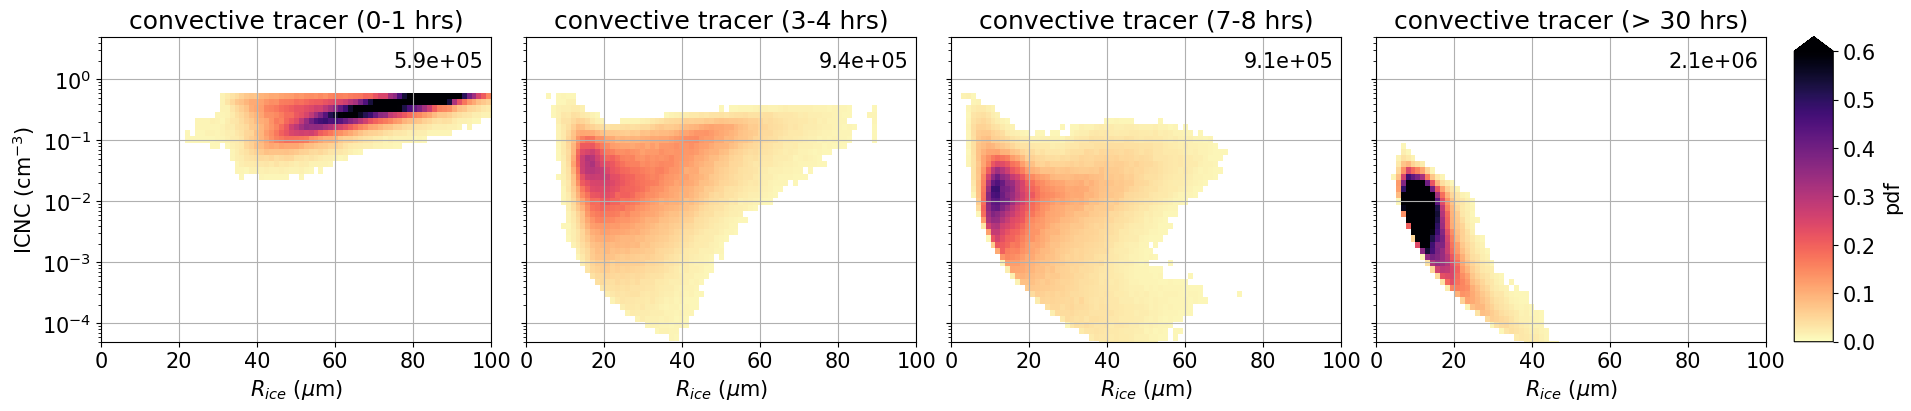

In [29]:
if tracer=="NUC":
    tracer_label = "nucleation tracer"
elif tracer=="BCU":
    tracer_label = "convective tracer"
ds = xr.open_dataset(mhist_stat_file)
fig, ax = plt.subplots(1, 5, figsize=(19,4),
                       width_ratios=[1,1,1,1,0.1],
                       constrained_layout=True)
xbins = ds.rice_bins
ybins = ds.icnc_bins

for i in range(4):
    # if i==3 & tracer=='BCU':
    #     continue
    hist = ds[f'{tracer}_{i}']
    n = int(hist.attrs['n'])
    hist = hist/n * 100
    hist = np.where(hist>0.01, hist, np.nan)
    im = ax[i].pcolormesh(xbins, ybins, hist.T,
                          cmap="magma_r", shading="auto",
                          vmin=0, vmax=0.6
                         )                          
    ax[i].annotate(f"{n:0.1e}", xy=(0.75, 0.9), xycoords="axes fraction")
    if i==0:
        tracer_low_thres, tracer_hgh_thres = 0, 1
    elif i==1:
        tracer_low_thres, tracer_hgh_thres = 3, 4
    elif i==2:
        tracer_low_thres, tracer_hgh_thres = 7, 8
    else:
        tracer_low_thres, tracer_hgh_thres = 30, None
    ax[i].set(yscale='log', xlabel="$R_{ice} \ (\mu$m)",
              xlim=[0,100], ylim=[5e-5,5]
             )
    ax[i].grid(True)
    if i>0:
        ax[i].set(yticklabels=[])
    # ax[i].set_axisbelow(True)
    if tracer_hgh_thres is not None:
        ax[i].set(title=f"{tracer_label} ({tracer_low_thres}-{tracer_hgh_thres} hrs)")
    else:
        ax[i].set(title=f"{tracer_label} (> {tracer_low_thres} hrs)")
ax[0].set(ylabel="ICNC (cm$^{-3}$)")
plt.colorbar(im, cax=ax[-1], label="pdf", shrink=0.9, extend="max")
savename=f"../plots/paperdraft/mhist_{tracer}_evolution_{run_name.lower().replace(" ","")}.png"
plt.savefig(savename)
plt.show()


### Part 3: plot the cdf of both tracers on one histogram

In [5]:
nuc = xr.open_dataset(file_name.replace("h0","NUC"), chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))['NUC']
bcu = xr.open_dataset(file_name.replace("h0","BCU"), chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))['BCU']
ds = xr.open_dataset(file_name, chunks=chunks).isel(lev=slice(30,80)).isel(time=slice(-nt,-1))[['IWC','T']]


In [6]:
mask = ((ds['IWC']>qsmall)&(ds['T']<233.15))
print("nuc...")
nuc = nuc.where(mask).values.flatten()
nuc = nuc[~np.isnan(nuc)]
print("bcu...")
bcu = bcu.where(mask).values.flatten()
bcu = bcu[~np.isnan(bcu)]
print("done. Total count is", end=" ")
n_nuc = len(nuc)
n_bcu = len(bcu)
print(f"NUC = {n_nuc} and BCU = {n_bcu}.")

nuc...
[########################################] | 100% Completed | 91.01 s
bcu...
[########################################] | 100% Completed | 85.98 s
done. Total count isNUC = 19047890 and BCU = 19047890.


In [14]:
bins = np.linspace(0,48,48)
bin_mids = (bins[1:]+bins[:-1])/2
hist_nuc, _ = np.histogram(nuc, bins=bins)
hist_bcu, _ = np.histogram(bcu, bins=bins)
hist_nuc = hist_nuc/n_nuc
hist_bcu = hist_bcu/n_bcu
hist_nuc = np.cumsum(hist_nuc)
hist_bcu = np.cumsum(hist_bcu)

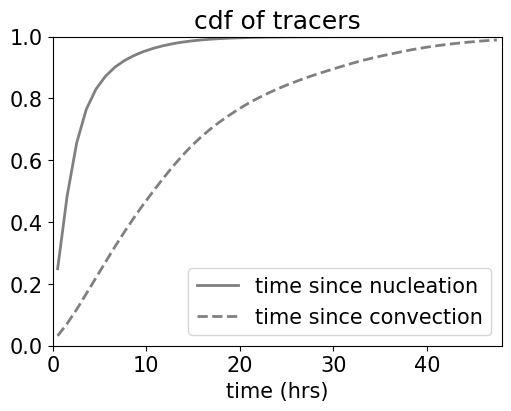

In [26]:
# plot it
fig, ax = plt.subplots(1,1,figsize=(5,4), constrained_layout=True)
ax.plot(bin_mids, hist_nuc, color='gray', lw=2,
        label="time since nucleation")
ax.plot(bin_mids, hist_bcu, color='gray', linestyle='dashed', lw=2,
        label="time since convection")
ax.set(xlim=[0,48], ylim=[0,1],
       xlabel="time (hrs)", title='cdf of tracers')
ax.legend()
savename = f"../plots/paperdraft/cdf_tracers_evolution_subplot_{run}.png"
plt.savefig(savename)
plt.show()

## Figure 3: Vertical velocity at nucleation for in-situ cirrus and the mphys properties

In [3]:
nuc = file_name.replace("h0","NUC")
bcu = file_name.replace("h0","BCU")
wnuc = file_name.replace("h0","W_NUC")
ice = xr.open_dataset(file_name, chunks=chunks)[['IWC','NUMICE','Q','T','CLDICE']].isel(lev=slice(30,80)).isel(time=slice(0,20))
nuc = xr.open_dataset(nuc, chunks=chunks).NUC.isel(lev=slice(30,80)).isel(time=slice(0,20))
bcu = xr.open_dataset(bcu, chunks=chunks).BCU.isel(lev=slice(30,80)).isel(time=slice(0,20))
wnuc = xr.open_dataset(wnuc, chunks=chunks).W_NUC.isel(lev=slice(30,80)).isel(time=slice(0,20))
wnuc = (wnuc.where((bcu>24) & (nuc<2) & (ice.IWC>qsmall)))*100  # cm/s
wnuc

<xarray.DataArray 'W_NUC' (time: 20, lev: 50, ncol: 147456)> Size: 590MB
dask.array<mul, shape=(20, 50, 147456), dtype=float32, chunksize=(20, 50, 10000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 160B 2000-02-09 00:00:00 ... 2000-02-13 18:00:00
  * lev      (lev) float64 400B 82.6 86.04 89.38 92.79 ... 494.9 514.4 534.3
Dimensions without coordinates: ncol

### Part 1: W_NUC cm/s for in situ cirrus

In [4]:
wnuc = wnuc.values.flatten()
wnuc = wnuc[~np.isnan(wnuc)]
wnuc

[########################################] | 100% Completed | 101.40 s


array([ 0.20547087,  0.21379772,  0.19277032, ...,  9.11566   ,
        2.1429045 , 16.940746  ], dtype=float32)

In [5]:
n = len(wnuc)
hist, bins = np.histogram(wnuc, bins=np.arange(0,10.1,0.5))
hist = hist/n
cdf = np.cumsum(hist)

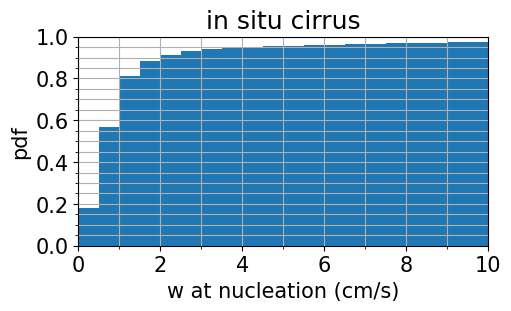

saved as ../plots/paperdraft/fig_W_NUC_insitu_ci_hist_NUC.lt.2_dpscream_rce_large_3km_LPLS_300K.png


In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,3), constrained_layout=True)
ax.bar(bins[:-1], cdf, align="edge")
ax.set(xlim=[0,10], ylim=[0,1], xlabel="w at nucleation (cm/s)", ylabel="pdf",
       title="in situ cirrus")
ax.set_yticks(np.arange(0,1.01,0.05), minor=True)
ax.set_yticks(np.arange(0,1.01,0.2))
ax.set_xticks(np.arange(0,10.1,1), minor=True)
ax.grid(True, which="both")
savename = f"../plots/paperdraft/fig_W_NUC_insitu_ci_hist_NUC.lt.2_{run}.png"
plt.savefig(savename)
plt.show()
print("saved as", savename)

### Part 2: cdf of in situ cirrus lifetime

In [29]:
nuc_strong = nuc.where(wnuc>10)
nuc_weak = nuc.where(wnuc<1)

In [30]:
nuc_strong = nuc_strong.values.flatten()
nuc_strong = nuc_strong[~np.isnan(nuc_strong)]

[########################################] | 100% Completed | 94.56 s


In [31]:
nuc_weak = nuc_weak.values.flatten()
nuc_weak = nuc_weak[~np.isnan(nuc_weak)]

[########################################] | 100% Completed | 89.07 s


In [32]:
n_strong = len(nuc_strong)
n_weak = len(nuc_weak)

In [33]:
bins = np.arange(0,24.1,0.5)
hist_strong, _ = np.histogram(nuc_strong, bins=bins)
hist_weak, _ = np.histogram(nuc_weak, bins=bins)
hist_strong = hist_strong/n_strong
hist_weak = hist_weak/n_weak
hist_strong = np.cumsum(hist_strong)
hist_weak = np.cumsum(hist_weak)


In [34]:
bin_mids = (bins[1:]+bins[:-1])/2

saved as ../plots/paperdraft/fig_W_NUC_insitu_ci_NUC_cdf_dpscream_rce_large_3km_LPLS_300K.png


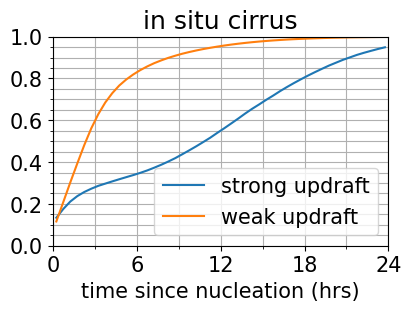

In [35]:
fig, ax = plt.subplots(1,1, figsize=(4,3), constrained_layout=True)
ax.plot(bin_mids, hist_strong, label="strong updraft")
ax.plot(bin_mids, hist_weak, label="weak updraft")
ax.set(title="in situ cirrus", xlabel="time since nucleation (hrs)",
       xlim=[0,24], ylim=[0,1])
ax.set_yticks(np.arange(0,1.01,0.05), minor=True)
ax.grid(which="both")
ax.set_xticks(np.arange(0,24.1,6))
ax.set_xticks(np.arange(0,24,3), minor=True)
savename=f"../plots/paperdraft/fig_W_NUC_insitu_ci_NUC_cdf_{run}.png"
print("saved as", savename)
ax.legend()
plt.savefig(savename, bbox_inches="tight")
plt.show()

### Part 3: mhist for slow and fast updrafts

In [4]:
which_wnuc = "strong"
fsmall=1e-4

In [10]:
rice = util.calc_rice(ice.CLDICE, ice.NUMICE)
icnc = util.calc_ni(ice.NUMICE, ice.Q, ice.lev*100, ice["T"])
if which_wnuc=="strong":
    rice_wnuc = rice.where((wnuc>=10)&(nuc<1))
    icnc_wnuc = icnc.where((wnuc>=10)&(nuc<1))
elif which_wnuc=="weak":
    rice_wnuc = rice.where((wnuc<1)&(nuc<2))
    icnc_wnuc = icnc.where((wnuc<1)&(nuc<2))
elif which_wnuc=="medium":
    rice_wnuc = rice.where((wnuc>=1)&(wnuc<10)&(nuc<2))
    icnc_wnuc = icnc.where((wnuc>=1)&(wnuc<10)&(nuc<2))
else:
    raise Exception(which_wnuc, "which_wnuc definition doesn't exist, try 'strong', 'medium', or 'weak'")

In [11]:
rice_bins=np.linspace(0,100,100)
icnc_bins=np.logspace(-5,2,70)

In [12]:
rice_flat = rice_wnuc.values.flatten()
icnc_flat = icnc_wnuc.values.flatten()
print(len(icnc_flat))
rice_flat = rice_flat[~np.isnan(icnc_flat)]
icnc_flat = icnc_flat[~np.isnan(icnc_flat)]
print(len(icnc_flat))

[########################################] | 100% Completed | 160.61 s
[########################################] | 100% Completed | 204.16 s
147456000
24466


In [13]:
hist, _, _, _ = stats.binned_statistic_2d(rice_flat,
                                          icnc_flat,
                                          None,
                                          statistic='count',
                                          bins=[rice_bins, icnc_bins])
stat = 'count'

xbins = (rice_bins[1:]+rice_bins[:-1])/2
ybins = (icnc_bins[1:]+icnc_bins[:-1])/2

n = np.nansum(hist)
print(n)
hist = hist/n
hist = np.where(hist>fsmall, hist, np.nan)


10838.0


plotting... 
... saved as ../plots/paperdraft/fig_mhist_count_dpscream_rce_large_3km_LPLS_300K_strong_f0.0001.png


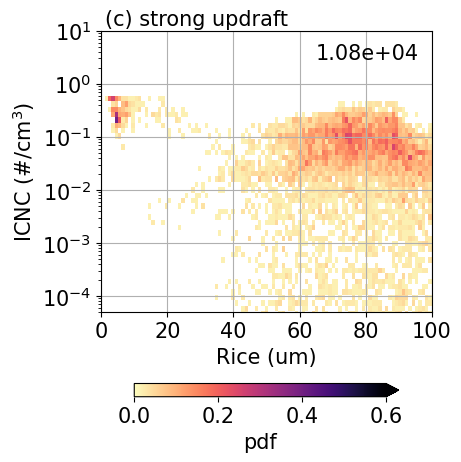

In [14]:
print("plotting... ")
fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5), constrained_layout=True)

cf = ax.pcolormesh(xbins, ybins,
                   (hist*100).T,
                   cmap="magma_r",
                   shading='auto',
                   vmin=0, vmax=0.6,
                   )
plt.colorbar(cf, ax=ax, label="pdf", location="bottom", shrink=0.8, extend='max')
ax.annotate(f"{n:0.2e}", xy=(0.65,0.9), xycoords="axes fraction")
ax.grid(True)
if which_wnuc=="weak":
    ax.annotate(f"(a) {which_wnuc} updraft", xy=(0.01,1.02), xycoords="axes fraction")
elif which_wnuc=="medium":
    ax.annotate(f"(b) {which_wnuc} updraft", xy=(0.01,1.02), xycoords="axes fraction")
elif which_wnuc=="strong":
    ax.annotate(f"(c) {which_wnuc} updraft", xy=(0.01,1.02), xycoords="axes fraction")

ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
savename = f"../plots/paperdraft/fig_mhist_count_{run}_{which_wnuc}_f{fsmall}.png"
plt.savefig(savename)
print("... saved as",savename)
plt.show()


----

# Supplemental figures

## SI Figure 1

Plot the initial condition/iop input files, especially for LS Ascent

In [10]:
iop_dir = "/glade/work/sturbeville/E3SM/inputdata/atm/cam/scam/iop/"
iop_file_def = iop_dir + "RCE_iopfile_4scam_no-mean-ascent.nc"
iop_file_ls = iop_dir + "RCE_iopfile_4scam_smooth_w_profile.nc"
iop_file_304k = iop_dir + "RCE_iopfile_4scam_smooth_w_profile_304ksst_new.nc"  # LPLS304K

In [11]:
ds_def = xr.open_dataset(iop_file_def).isel(time=0).isel(lat=0).isel(lon=0)
ds_ls = xr.open_dataset(iop_file_ls).isel(time=0).isel(lat=0).isel(lon=0)
ds_304k = xr.open_dataset(iop_file_304k).isel(time=0).isel(lat=0).isel(lon=0)

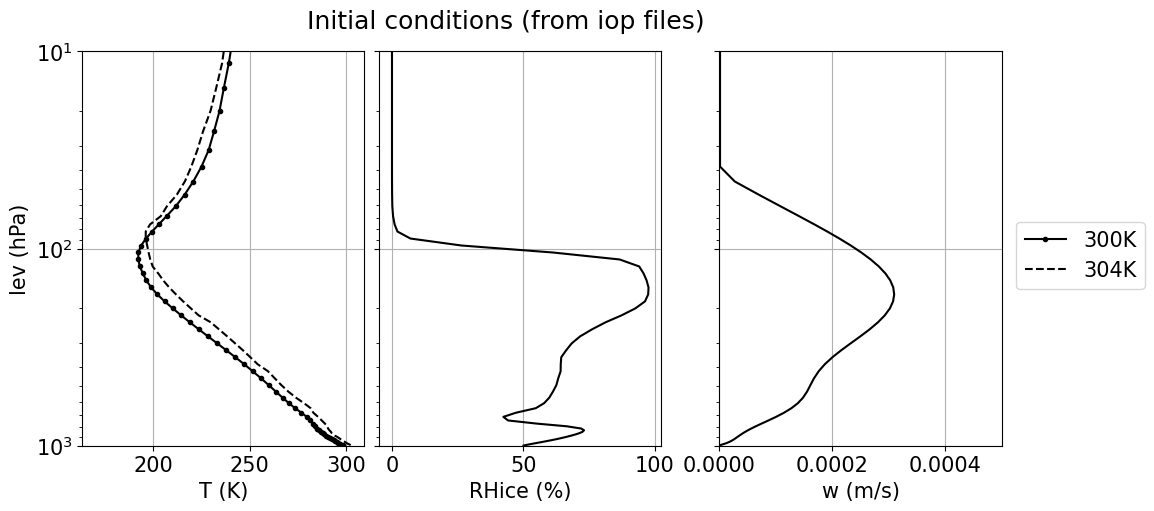

In [21]:

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True, constrained_layout=True)
ax[0].plot(ds_def['T'], ds_def.lev/100, label="300K",
           color='k', marker='.')
ax[0].plot(ds_304k['T'], ds_304k.lev/100, label="304K",
           color='k', linestyle='dashed')
ax[1].plot(util.calc_rhice(ds_def, varQ="q", z_units="Pa"), ds_def.lev/100,
           color='k')
ax[2].plot(util.omega2w(ds_ls['omega'], ds_ls.lev.values, ds_ls['T'].values),
           ds_ls.lev/100, color='k')
ax[2].set(xlim=[0,0.0005])
ax[0].set(xlabel="T (K)", ylabel="lev (hPa)")
ax[1].set(xlabel="RHice (%)")
ax[2].set(xlabel="w (m/s)")
for i in range(3):
    ax[i].grid(True)
fig.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax[0].set(ylim=[1000,10], yscale="log")
fig.suptitle("Initial conditions (from iop files)")
plt.savefig("../plots/paperdraft/sifig01_iop_profiles_T_w_omega.pdf", bbox_inches="tight", pad_inches=0.5)
plt.show()


# SI Figure 2: mean PW over 10 day periods

number of 10 day periods: 5 - timestep (hrs): 6 - number of timesteps in a ten day period: 40
0
10 days for day 0 10 2000-01-01 00:00:00 2000-01-11 00:00:00
[########################################] | 100% Completed | 4.76 sms
[########################################] | 100% Completed | 4.57 sms
[########################################] | 100% Completed | 4.17 sms
[########################################] | 100% Completed | 120.20 ms
mean pw 35.31578063964844
1
10 days for day 10 20 2000-01-11 00:00:00 2000-01-21 00:00:00
[########################################] | 100% Completed | 113.46 ms
[########################################] | 100% Completed | 118.85 ms
[########################################] | 100% Completed | 115.07 ms
[########################################] | 100% Completed | 120.00 ms
mean pw 32.875877380371094
2
10 days for day 20 30 2000-01-21 00:00:00 2000-01-31 00:00:00
[########################################] | 100% Completed | 118.34 ms
[################

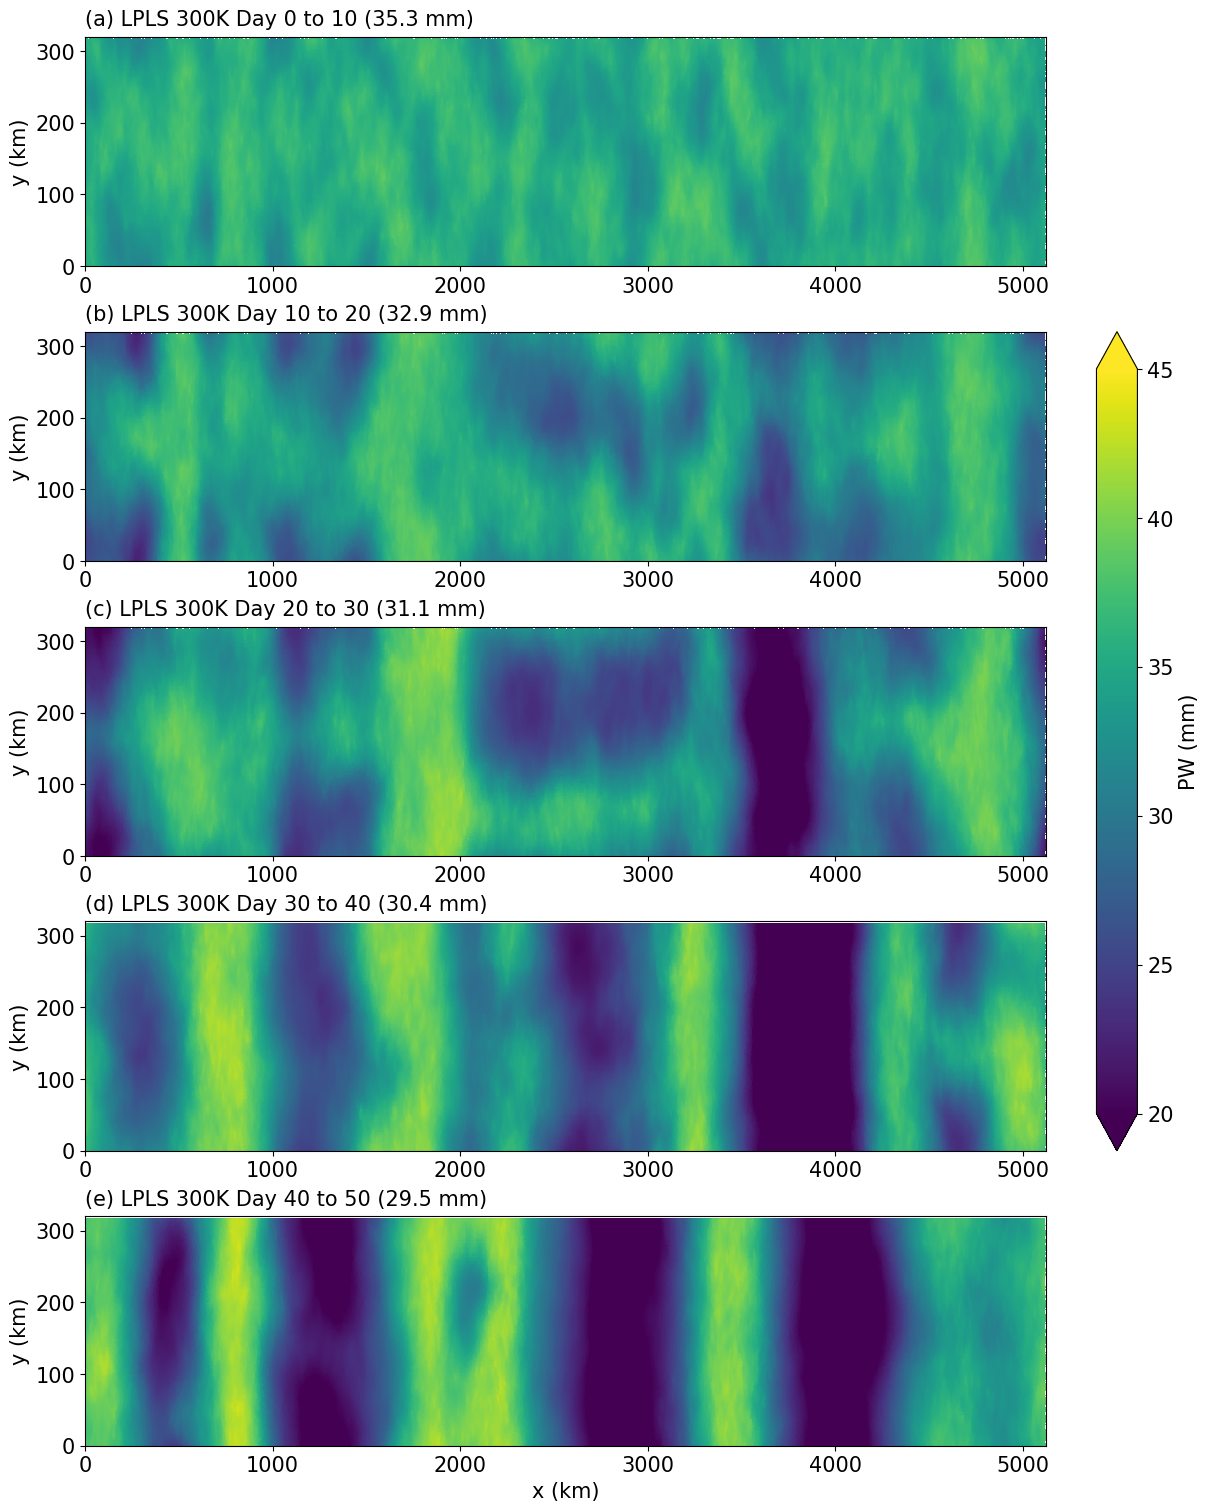

In [4]:
# zonal mean PW over the last five days of the simulation
run = "dpscream_rce_large_3km_LPLS_300K"
run_name = "LPLS 300K"
ndays=10
file_name = f"{sims_dir}/{run}/run/{run}.eam.h1.2000-01-01-00000.nc"
ds = xr.open_dataset(file_name, chunks={'time':200,'ncol':2000})[['time','TMQ','crm_grid_y','crm_grid_x']]
# ds = ds.set_coords(['crm_grid_y','crm_grid_x'])
tstep = ((ds.time[1]-ds.time[0]).astype('timedelta64[s]').astype('int')//3600).values
nt_10days = (ndays*24)//tstep
n_10day_periods = 5  # int(((ds.time[-1]-ds.time[0]).astype('timedelta64[s]').astype('int')//3600)//240)
print('number of 10 day periods:', n_10day_periods, '- timestep (hrs):', tstep, '- number of timesteps in a ten day period:', nt_10days)
fig, ax = plt.subplots(n_10day_periods,1, figsize=(12,n_10day_periods*3), layout='constrained')
savename="PWmean_10dayperiods"
for i in range(n_10day_periods):
    print(i)
    d0 = i*nt_10days
    d1 = nt_10days*(i+1)
    print(int((ds.time[d1]-ds.time[d0]).astype('timedelta64[s]').astype('int'))//3600//24, 'days for day', i*10, (i+1)*10, ds.time[d0].values, ds.time[d1].values)
    ds_10days = ds.isel(time=slice(d0,d1)).mean(dim=['time'])
    im = ax[i].tripcolor(ds_10days.crm_grid_y.values/1000, ds_10days.crm_grid_x.values/1000,
                         ds_10days.TMQ.values, cmap='viridis', vmin=20, vmax=45)
    ax[i].set(ylabel="y (km)")
    pw_mean = float(ds_10days.TMQ.mean().values)
    print("mean pw", pw_mean)
    ax[i].annotate(f"({(chr(ord('`')+i+1))}) {run_name} Day {i*10} to {(i+1)*10} ({pw_mean:0.1f} mm)", xy=(0.0,1.05), xycoords="axes fraction")
    ax[i].set(xlim=[0,5120], ylim=[0,320])
ax[-1].set(xlabel="x (km)")
plt.colorbar(im, ax=ax[n_10day_periods//2-1:n_10day_periods//2+2], extend='both', label="PW (mm)")
savename = f"../plots/paperdraft/fig03_PWmean_last{ndays}days_{savename}_{run_name.replace(" ","_")}.png"
plt.savefig(savename,bbox_inches="tight", pad_inches=0.5)
print(f"saved as {savename}")
plt.show()

# SI FIG 3?